# Investigate sanity of data in VRE relevant CDWH tables

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

For the VRE Research Project, we require data from the time range 01.01.2018-31.03.2020 and the patients should be inpatients (stationary) and of type 'Standard Patient'. From within these constraints, we require the following data:

* Patient Case data - Cases treated within the hospital context

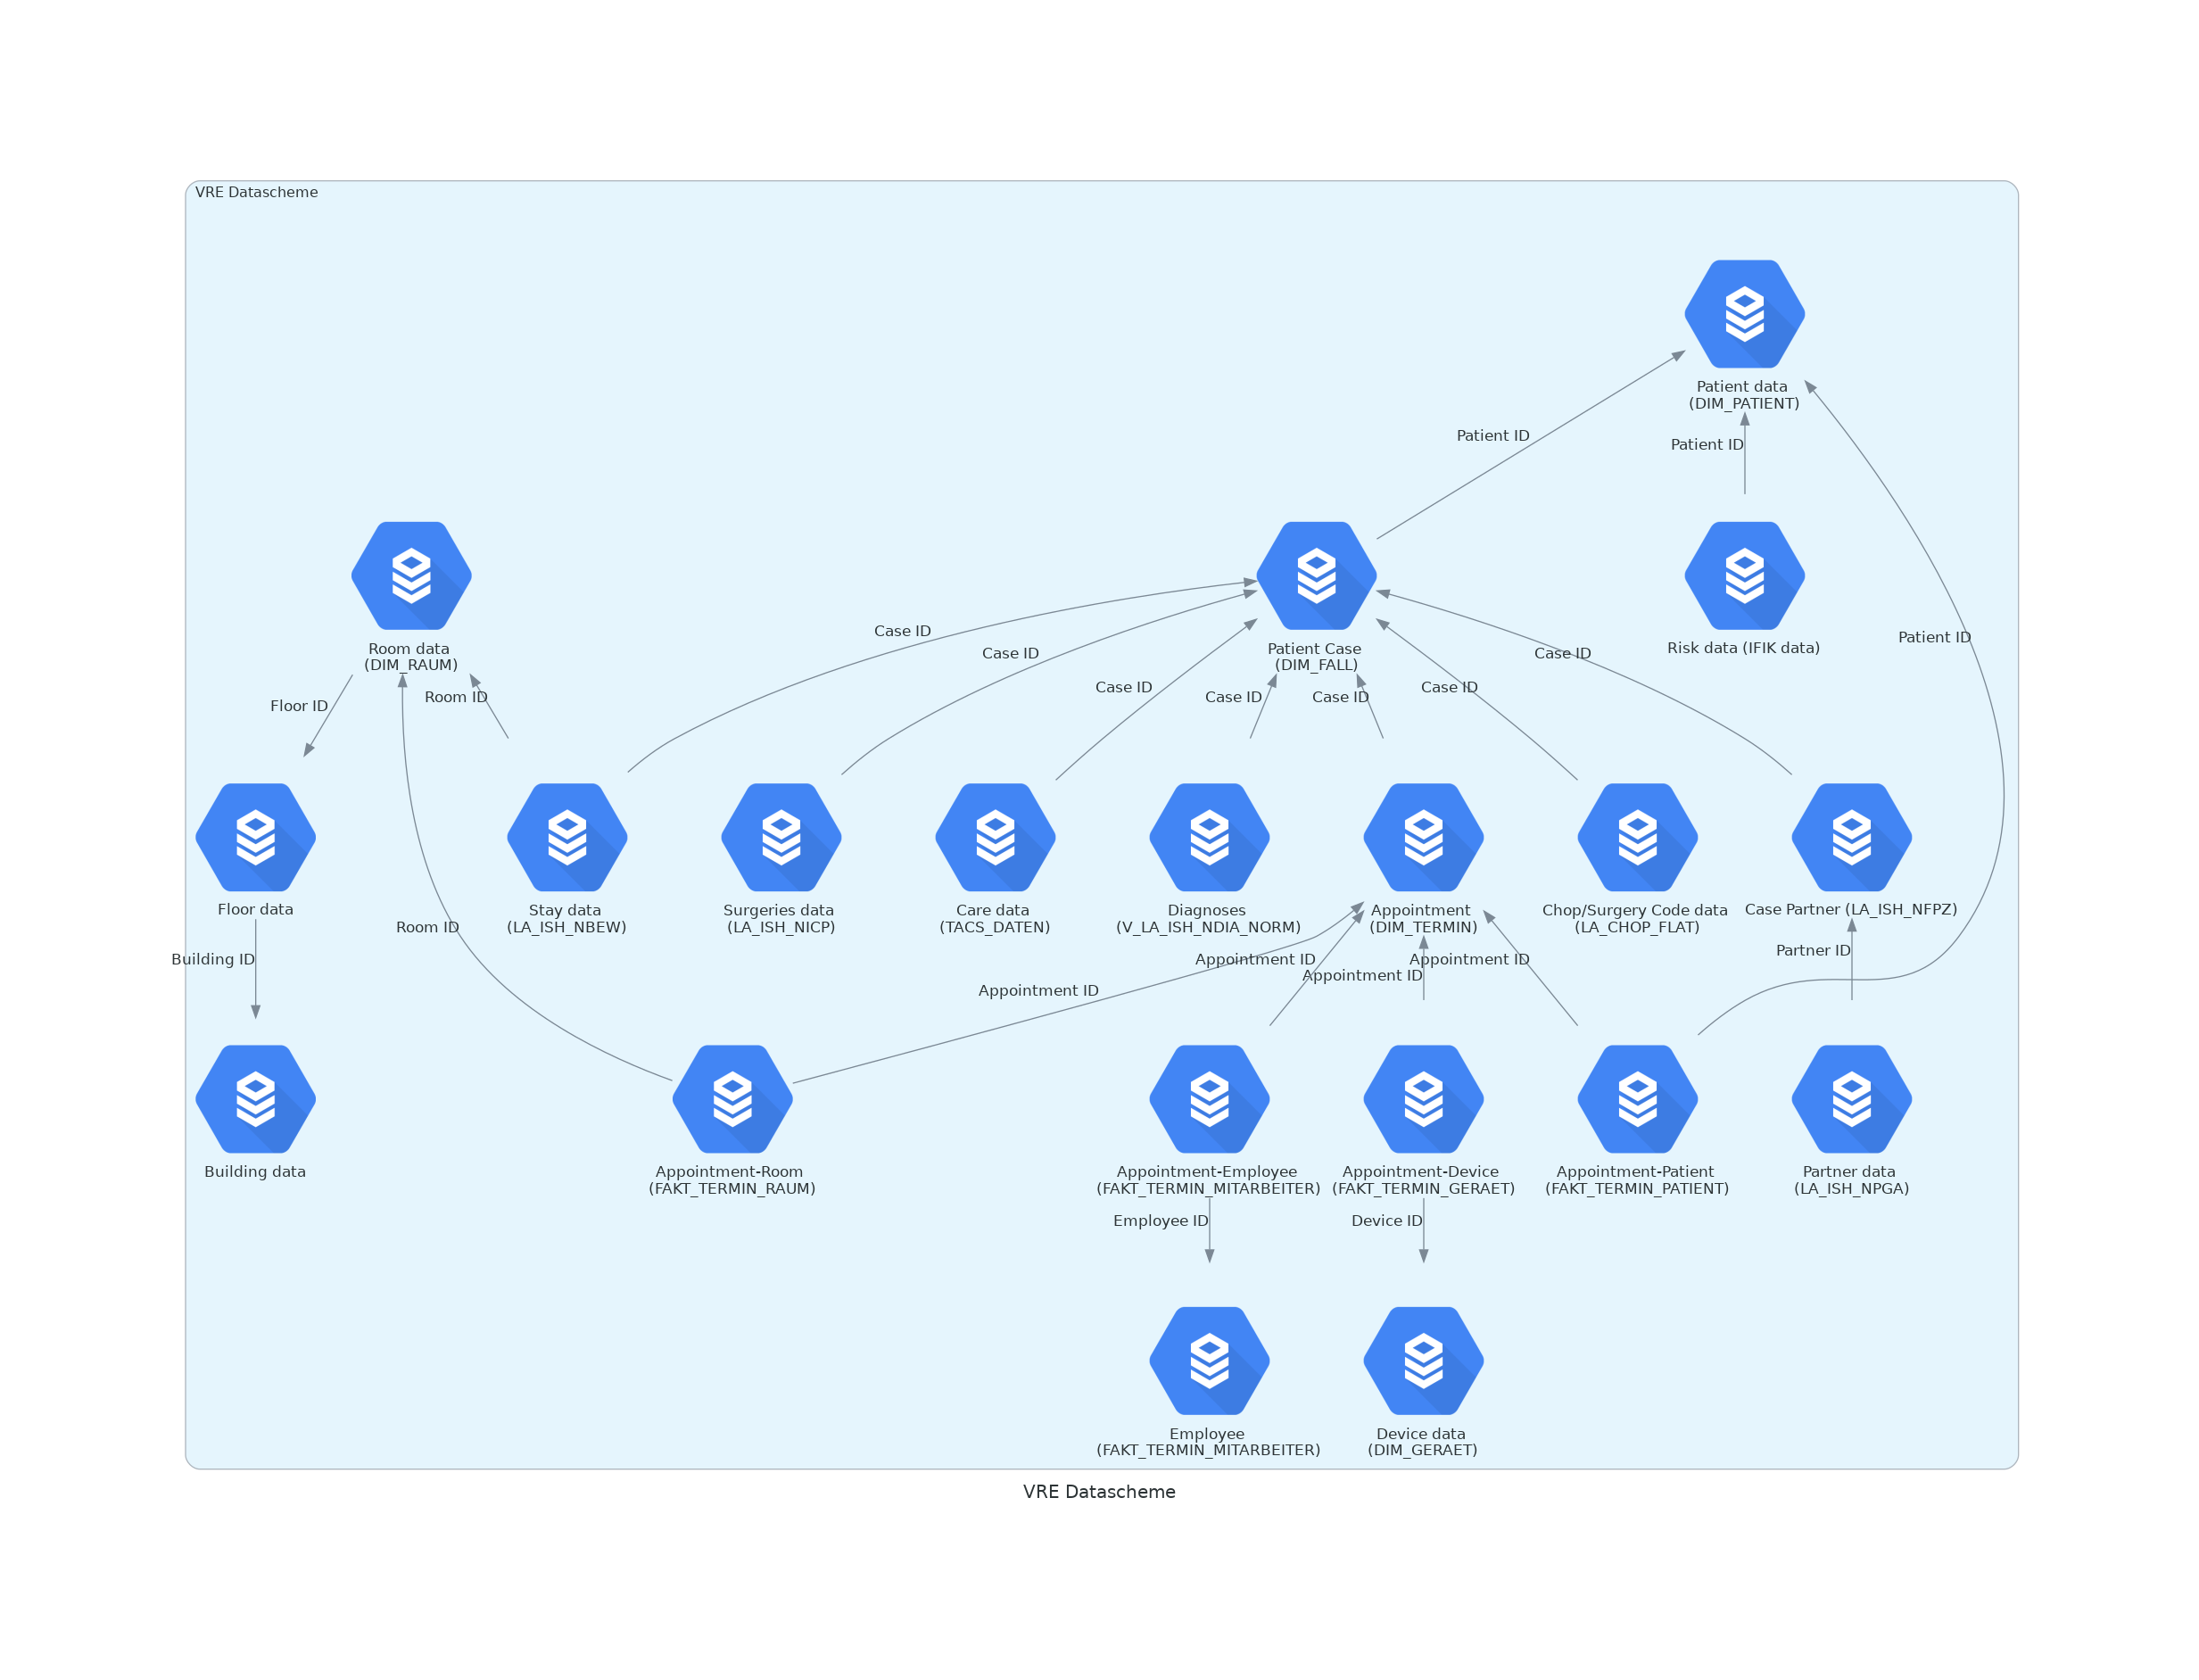

In [2]:
from diagrams import Cluster, Diagram, Edge
from diagrams.gcp.database import SQL

graph_attr = {
#     "splines": "polyline",
    "splines": "spline",
#     "splines":"curved",
    "concentrate":"true",
    "nodesep":"1.1",
}

edge_attr = {
    "minlen":"1"
}

with Diagram("VRE Datascheme", show=False, graph_attr=graph_attr, edge_attr=edge_attr, outformat='png', direction="TB") as diag:
    
    with Cluster("VRE Datascheme"):
        
        # draw edges
#       with Cluster("linked by Patient ID"):
        patient_node = SQL("Patient data \n(DIM_PATIENT)")
        risk_node = SQL("Risk data (IFIK data)")

#             with Cluster("linked by Case ID"):
        case_node = SQL("Patient Case \n(DIM_FALL)")
        stay_node = SQL("Stay data \n(LA_ISH_NBEW)")
        case_partner_node = SQL("Case Partner (LA_ISH_NFPZ)")
        partner_node = SQL("Partner data \n(LA_ISH_NPGA)")
        care_node = SQL("Care data \n(TACS_DATEN)")
        icd10_code_node = SQL("Diagnoses \n(V_LA_ISH_NDIA_NORM)")
        chop_code_node = SQL("Chop/Surgery Code data \n(LA_CHOP_FLAT)")
        surgery_node = SQL("Surgeries data \n(LA_ISH_NICP)")

#                 with Cluster("linked by Appointment ID"):
        appointment_node = SQL("Appointment \n(DIM_TERMIN)")
        appointment_patient_node = SQL("Appointment-Patient \n(FAKT_TERMIN_PATIENT)")
        appointment_device_node = SQL("Appointment-Device \n(FAKT_TERMIN_GERAET)")
        device_node = SQL("Device data \n(DIM_GERAET)")
        appointment_room_node = SQL("Appointment-Room \n(FAKT_TERMIN_RAUM)")
        appointment_employee_node = SQL("Appointment-Employee \n(FAKT_TERMIN_MITARBEITER)")
        employee_node = SQL("Employee \n(FAKT_TERMIN_MITARBEITER)")

        appointment_node << Edge(xlabel="Appointment ID") << [appointment_patient_node,
                                                             appointment_device_node,
                                                             appointment_room_node,
                                                             appointment_employee_node]
        
        appointment_device_node >> Edge(xlabel="Device ID") >> device_node
        appointment_employee_node >> Edge(xlabel="Employee ID") >> employee_node


        case_node << Edge(xlabel="Case ID") << [stay_node,
                                               case_partner_node,
                                               chop_code_node,
                                               surgery_node,
                                               appointment_node,
                                               care_node,
                                               icd10_code_node]

        case_partner_node << Edge(xlabel="Partner ID") << partner_node

        patient_node << Edge(xlabel="Patient ID") << [case_node,
                                                     risk_node,
                                                     appointment_patient_node]
            
#         with Cluster("linked by Room ID"):
        room_node = SQL("Room data \n(DIM_RAUM)")
        floor_node = SQL("Floor data")
        building_node = SQL("Building data")
        room_node >> Edge(xlabel="Floor ID") >> floor_node >> Edge(xlabel="Building ID") >> building_node
        room_node << Edge(xlabel="Room ID") << [appointment_room_node,
                                                stay_node]
    
diag

In [3]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')
os.chdir("../")

base_folder = "./data/processed/delivery/stats/DWH Export/"


Bad key savefig.frameon in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.

## Utility functions

### Get class of colums

In [4]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def evaluate_col_classes(df):
    for column_name in df.columns:
        if is_string_dtype(df[column_name].dtype):  # the column is probably categorical if correctly encoded
            print('CATEGORICAL: Column name: {0}, dtype: {1}, values: {2}'
                  .format(column_name,
                    df[column_name].dtype,
                    df[column_name].unique()))
        elif is_numeric_dtype(df[column_name].dtype.name): # the column is probably numerical if correctly encoded
            unique_vals = df[column_name].unique()

            if len(unique_vals) > 100: # magic number
                print('NUMERICAL: Column name: {0}, dtype: {1}, #qty unique values: {2}'
                      .format(column_name,
                      df[column_name].dtype,
                      len(unique_vals)))
            else:
                print('NUMERICAL/POSSIBLY CATEGORICAL: Column name: {0}, dtype: {1}, unique values (#qty): {2}, ({3})'
                      .format(column_name,
                      df[column_name].dtype,
                      sorted(unique_vals),
                      len(unique_vals)))

        else: # what kind of type is this?
            print('UNKNOWN: Column name: {0}, dtype: {1}, class: numerical'
                  .format(column_name,
                   df[column_name].dtype))


### Plot histogram of dates

In [5]:
def plot_date_histogram_of_col(df, col="date", by_month=False):
    col_s = df[col].dropna()
    if not by_month:
        col_s.groupby([col_s.dt.year]).count().plot(kind="bar", figsize=(16,12))
    else:
        col_s.groupby([col_s.dt.year, col_s.dt.month]).count().plot(kind="bar", figsize=(16,12))

### Extend count set by missing patients to get median count of all patients
* left-join with all patients
* Replace value when it is NA

In [6]:
def extend_by_missing_patients(patient_df, all_patient_df, na_find=None, na_replace=None):
    extend_patient_df = all_patient_df.merge(patient_df, how="left", on="dim_patient_sid")
    if na_find is not None and na_replace is not None:
        extend_patient_df[na_find] = extend_patient_df[na_find].fillna(na_replace)
        
    return extend_patient_df

## dd_cases

In [7]:
dim_case_df = pd.read_csv(base_folder + "dd_cases.csv", dtype=str, parse_dates=["dim_fall_start_datum", 'dim_fall_ende_datum']) #, encoding="ISO-8859-1")

In [8]:
dim_case_df

,dim_fall_sid,dim_fall_bk,dim_fall_fid_int,dim_patient_sid,dim_fall_patient_bk,fall_status,dim_fall_start_datum,dim_fall_ende_datum
0,6439317,0006945979,6945979,1018960,00008667896,Fall ist abgeschlossen,2019-02-10,1753-01-01
1,6439333,0006946072,6946072,1332007,00014346540,Fall ist abgeschlossen,2019-02-10,1753-01-01
2,6439340,0006946124,6946124,795595,00011705647,Fall ist abgeschlossen,2019-02-10,1753-01-01
3,6439342,0006946318,6946318,1308800,00083038116,Fall ist abgeschlossen,2019-02-10,1753-01-01
4,6439356,0006946324,6946324,321215,00006286445,Fall ist abgeschlossen,2019-02-10,1753-01-01
...,...,...,...,...,...,...,...,...
157967,6561722,0007058216,7058216,809174,00009882880,Fall ist abgeschlossen,2019-04-19,1753-01-01
157968,6561737,0007058260,7058260,431307,00004268083,Fall ist abgeschlossen,2019-04-19,1753-01-01
157969,6561772,0007058352,7058352,1652413,00015383369,Fall ist abgeschlossen,2019-04-19,1753-01-01
157970,6561804,0007058041,7058041,1330784,00014788900,Fall ist abgeschlossen,2019-04-19,1753-01-01


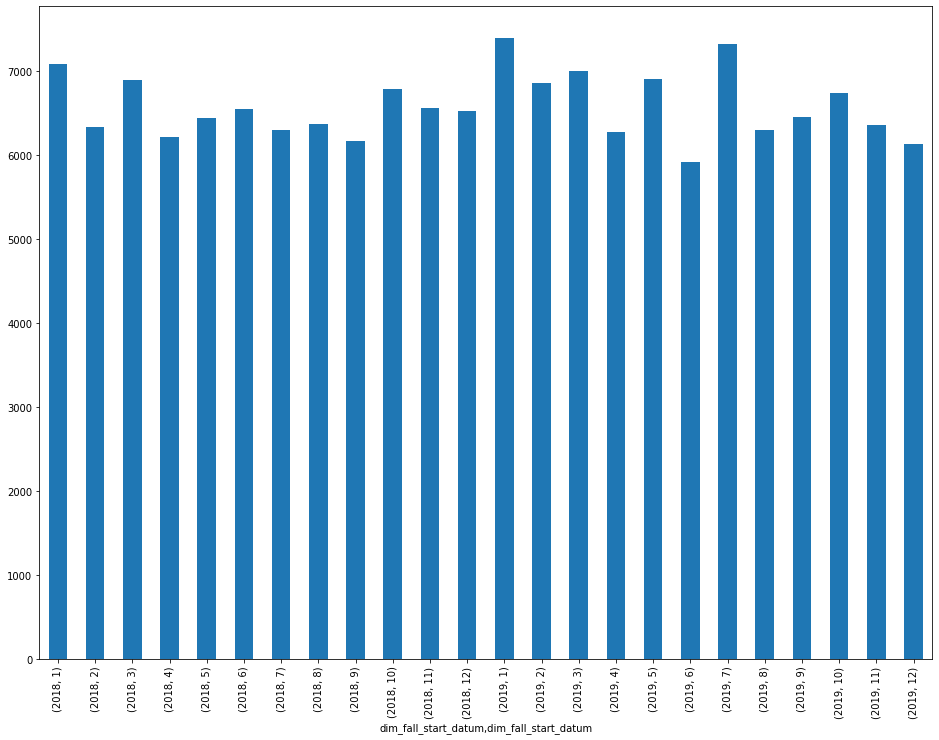

In [9]:
plot_date_histogram_of_col(dim_case_df, col="dim_fall_start_datum", by_month=True)

### Plot histogram of enddates

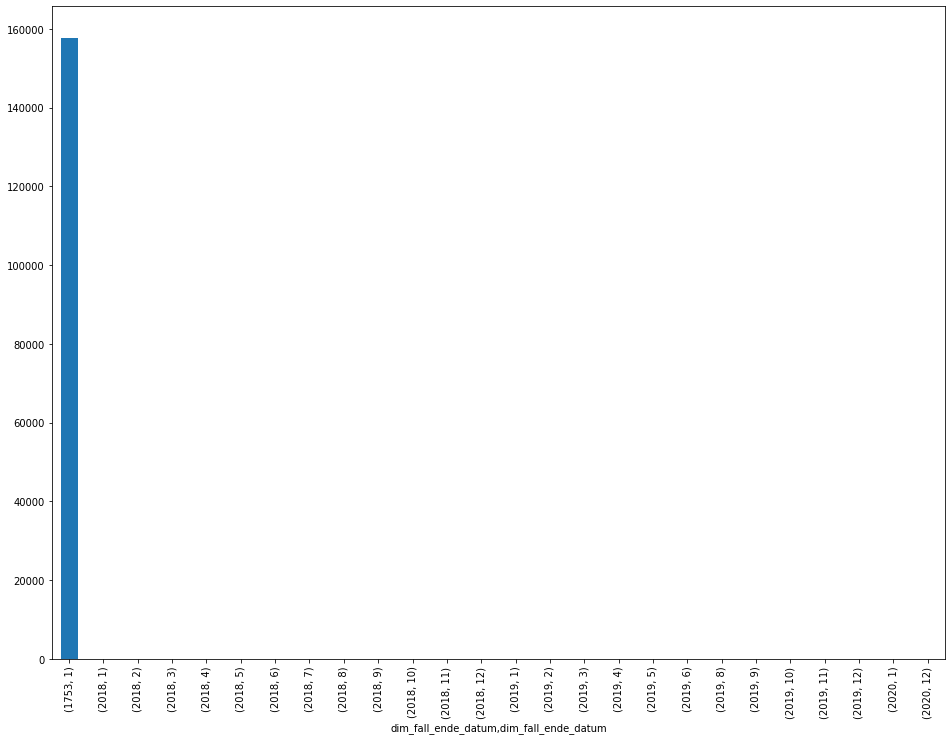

In [10]:
import datetime
plot_date_histogram_of_col(dim_case_df, col="dim_fall_ende_datum", by_month=True)

### Evaluate data types of patient cases

In [11]:
evaluate_col_classes(dim_case_df)

CATEGORICAL: Column name: dim_fall_sid, dtype: object, values: ['6439317' '6439333' '6439340' ... '6561772' '6561804' '6561805']
CATEGORICAL: Column name: dim_fall_bk, dtype: object, values: ['0006945979' '0006946072' '0006946124' ... '0007058352' '0007058041'
 '0007058064']
CATEGORICAL: Column name: dim_fall_fid_int, dtype: object, values: ['6945979' '6946072' '6946124' ... '7058352' '7058041' '7058064']
CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['1018960' '1332007' '795595' ... '809174' '1652413' '525409']
CATEGORICAL: Column name: dim_fall_patient_bk, dtype: object, values: ['00008667896' '00014346540' '00011705647' ... '00009882880' '00015383369'
 '00000810991']
CATEGORICAL: Column name: fall_status, dtype: object, values: ['Fall ist abgeschlossen' 'Fall ist aktuell']
UNKNOWN: Column name: dim_fall_start_datum, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: dim_fall_ende_datum, dtype: datetime64[ns], class: numerical


### Evaluate number of cases per patient

<AxesSubplot:xlabel='case_counts'>

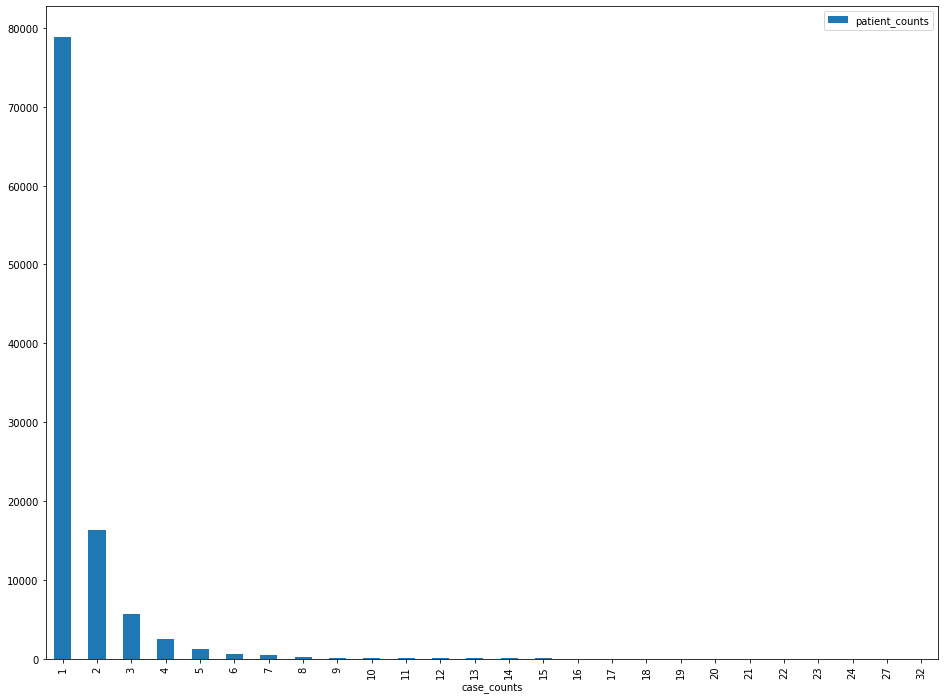

In [12]:
dim_case_df.groupby(['dim_patient_sid']).size().reset_index(name='case_counts').sort_values(by='case_counts')\
 .groupby(["case_counts"]).size().reset_index(name='patient_counts').set_index("case_counts").sort_values(by='case_counts').plot(kind="bar", figsize=(16,12))

## dd_patients

In [13]:
dim_patient_df = pd.read_csv(base_folder + "dd_patients.csv", dtype=str, parse_dates=["dim_patient_geburtsdatum"])

In [14]:
dim_patient_df

,dim_patient_sid,dim_patient_bk,dim_patient_pid_int,dim_patient_vorname,dim_patient_nachname,dim_patient_geschlecht,dim_patient_geburtsdatum
0,28451,00004703669,4703669,Margrit,Karner,weiblich,1947-04-10
1,28619,00002810131,2810131,Urs,Bächli,männlich,1949-06-28
2,28652,00002810514,2810514,Yunus,Güçtekin,männlich,1963-01-01
3,28667,00002810697,2810697,Hans,Bolliger,männlich,1925-11-18
4,28683,00002810867,2810867,Erika,Hirschi,weiblich,1945-02-07
...,...,...,...,...,...,...,...
106198,87338,00004323904,4323904,Steve,Blum,männlich,1980-03-21
106199,87370,00004324285,4324285,Renata,Baum,weiblich,1949-08-30
106200,87371,00004324293,4324293,Sandra,Fischer,weiblich,1964-02-17
106201,87720,00002161176,2161176,Tahir,Krasniqi,männlich,1948-02-19


### Plot histogram of birthdates

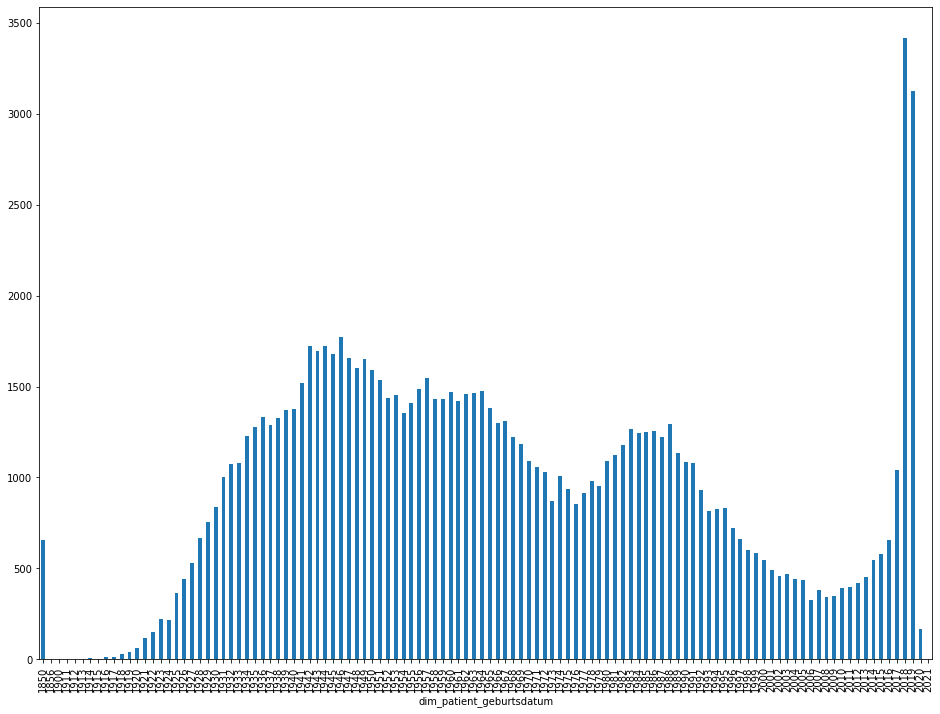

In [15]:
plot_date_histogram_of_col(dim_patient_df, col="dim_patient_geburtsdatum", by_month=False)

In [16]:
dim_patient_df[dim_patient_df["dim_patient_geburtsdatum"] > datetime.datetime(2019,1,1)]

,dim_patient_sid,dim_patient_bk,dim_patient_pid_int,dim_patient_vorname,dim_patient_nachname,dim_patient_geschlecht,dim_patient_geburtsdatum
40667,984077,00012886645,12886645,Noar,Pashaliu,männlich,2019-03-06
48195,1125359,00014614235,14614235,Anja,Ramseier,weiblich,2021-02-28
60728,1274492,00014959909,14959909,Jonas Maxime,Haar,männlich,2019-01-23
61116,1215016,00014940710,14940710,Julian Christian,Wagenknecht,männlich,2019-02-07
69274,1314252,00014859181,14859181,Semahal,Abraha,weiblich,2019-01-22
...,...,...,...,...,...,...,...
105217,1945978,00015842142,15842142,Elina,Ingold,weiblich,2019-06-30
105226,1946237,00015845532,15845532,Louis,Gret,männlich,2020-01-27
105227,1946260,00015846369,15846369,Osmon,Kameraj,männlich,2019-05-12
105233,1946337,00015846024,15846024,Yaël,Eggertswyler,weiblich,2019-12-30


Looks like a demographic curve. So that is all great.

### Plot pretty unrealistic birth dates in the table

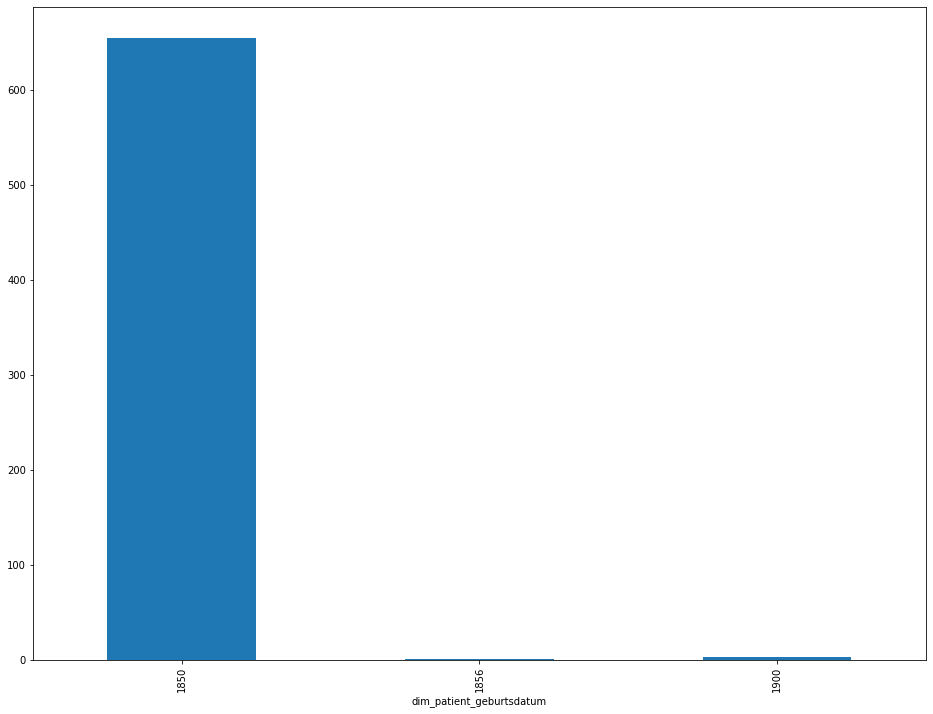

In [17]:
condition = (dim_patient_df["dim_patient_geburtsdatum"] <= pd.to_datetime("1900-01-01")) & (dim_patient_df["dim_patient_geburtsdatum"] > pd.to_datetime("1754-01-01"))
plot_date_histogram_of_col(dim_patient_df[condition], col="dim_patient_geburtsdatum", by_month=False)

Some of those seem to be dates mean to be placeholders, but they are a bit fancy.

### Evaluate data types of patient data

In [18]:
evaluate_col_classes(dim_patient_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['28451' '28619' '28652' ... '87371' '87720' '87740']
CATEGORICAL: Column name: dim_patient_bk, dtype: object, values: ['00004703669' '00002810131' '00002810514' ... '00004324293' '00002161176'
 '00003106756']
CATEGORICAL: Column name: dim_patient_pid_int, dtype: object, values: ['4703669' '2810131' '2810514' ... '4324293' '2161176' '3106756']
CATEGORICAL: Column name: dim_patient_vorname, dtype: object, values: ['Margrit' 'Urs' 'Yunus' ... 'Sara Priscilla' 'Haci Ibrahim' 'Sarah Zita']
CATEGORICAL: Column name: dim_patient_nachname, dtype: object, values: ['Karner' 'Bächli' 'Güçtekin' ... 'Bürer' 'Becirbegovic' 'Llano']
CATEGORICAL: Column name: dim_patient_geschlecht, dtype: object, values: ['weiblich' 'männlich' nan]
UNKNOWN: Column name: dim_patient_geburtsdatum, dtype: datetime64[ns], class: numerical


### Do all cases have a patient?

In [19]:
dim_case_df.merge(dim_patient_df, how="left", on="dim_patient_sid")

,dim_fall_sid,dim_fall_bk,dim_fall_fid_int,dim_patient_sid,dim_fall_patient_bk,fall_status,dim_fall_start_datum,dim_fall_ende_datum,dim_patient_bk,dim_patient_pid_int,dim_patient_vorname,dim_patient_nachname,dim_patient_geschlecht,dim_patient_geburtsdatum
0,6439317,0006945979,6945979,1018960,00008667896,Fall ist abgeschlossen,2019-02-10,1753-01-01,00008667896,8667896,Franz,Lutz,männlich,1925-02-09
1,6439333,0006946072,6946072,1332007,00014346540,Fall ist abgeschlossen,2019-02-10,1753-01-01,00014346540,14346540,Benjamin,Eigl,männlich,1992-07-22
2,6439340,0006946124,6946124,795595,00011705647,Fall ist abgeschlossen,2019-02-10,1753-01-01,00011705647,11705647,Willi,Heiniger,männlich,1932-07-17
3,6439342,0006946318,6946318,1308800,00083038116,Fall ist abgeschlossen,2019-02-10,1753-01-01,00083038116,83038116,Philine,Beyeler,weiblich,2001-08-11
4,6439356,0006946324,6946324,321215,00006286445,Fall ist abgeschlossen,2019-02-10,1753-01-01,00006286445,6286445,Patric,Winkler,männlich,1976-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157967,6561722,0007058216,7058216,809174,00009882880,Fall ist abgeschlossen,2019-04-19,1753-01-01,00009882880,9882880,Evelyne,Reymond,weiblich,1955-01-26
157968,6561737,0007058260,7058260,431307,00004268083,Fall ist abgeschlossen,2019-04-19,1753-01-01,00004268083,4268083,Bedrije,Hoxha,weiblich,1965-05-15
157969,6561772,0007058352,7058352,1652413,00015383369,Fall ist abgeschlossen,2019-04-19,1753-01-01,00015383369,15383369,Helene,Fasel,weiblich,1945-11-15
157970,6561804,0007058041,7058041,1330784,00014788900,Fall ist abgeschlossen,2019-04-19,1753-01-01,00014788900,14788900,Urs,Moor,männlich,1955-07-28


### Get all patients df

In [20]:
all_patients_df = dim_patient_df[["dim_patient_sid", "dim_patient_bk"]]

## dd_charlson_scores

In [21]:
dim_charlson_scores_df = pd.read_csv(base_folder + "dd_charlson_scores.csv", dtype=str)

In [22]:
dim_charlson_scores_df

,dim_fall_sid,dim_patient_sid,dim_patient_bk,fakt_comorbidity_scores_charlson_weighted
0,3005235,699219,00009937633,1
1,5313794,1070484,00014603497,10
2,4809130,388391,00006619177,4
3,5095923,1132923,00009358625,5
4,2972540,532137,00001482262,0
...,...,...,...,...
159592,7047938,442871,00001013890,0
159593,7017753,1238370,00014475847,6
159594,4849852,1172325,00011782676,0
159595,6664302,50634,00001137115,0


In [23]:
dim_case_df.merge(dim_charlson_scores_df, how="left", on="dim_patient_sid")["fakt_comorbidity_scores_charlson_weighted"].isna().sum()

53558

Why do we miss charlson scores? Because some cases miss the comorbidities to score them appropriately.

## dd_icu_stays

In [24]:
dim_icu_stays_df = pd.read_csv(base_folder + "dd_icu_stays.csv", dtype=str, parse_dates=["fakt_patient_bewegung_date"])

In [25]:
dim_icu_stays_df

,dim_patient_sid,dim_fall_sid,fakt_patient_bewegung_zimmer,fakt_patient_bewegung_class,fakt_patient_bewegung_date
0,1107557,5017462,BH E 108,0003,2018-06-13 12:15:00
1,1333494,5427989,BH E 108,0003,2018-07-13 10:00:00
2,743172,5055957,INE BL01,0003,2018-08-06 05:00:00
3,1038710,6345949,BH E 114,0003,2018-12-17 12:20:00
4,74014,6552404,INE GR03,0003,2019-04-14 11:45:00
...,...,...,...,...,...
11597,1099061,5345760,BH E 114,0003,2018-04-26 15:30:00
11598,751429,5685273,BH E 109,0003,2018-05-29 16:30:00
11599,10210,6777474,BH E 121,0003,2019-08-29 13:50:00
11600,1929683,7057909,BH E 113,0003,2019-10-06 17:51:00


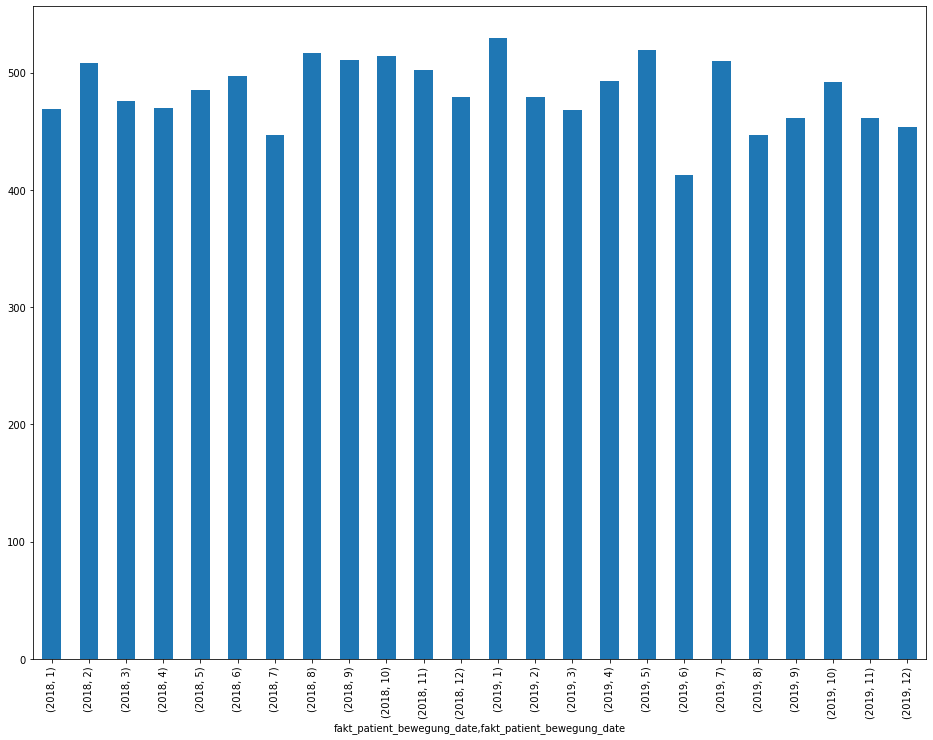

In [26]:
plot_date_histogram_of_col(dim_icu_stays_df, col="fakt_patient_bewegung_date", by_month=True)

### Number of patients with number of ICU stays

<AxesSubplot:xlabel='stay_counts'>

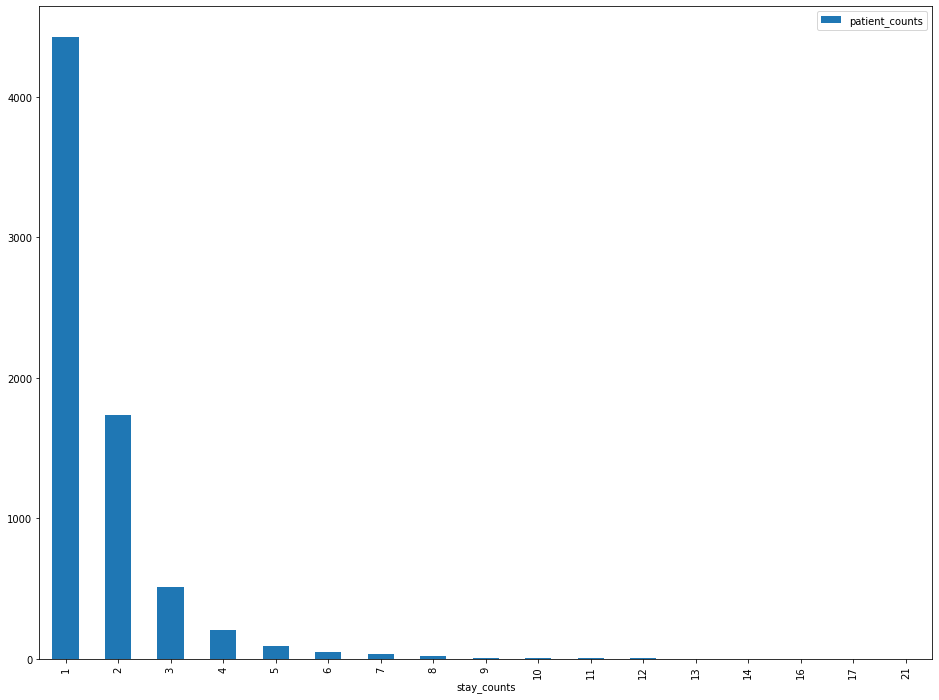

In [27]:
dim_icu_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='stay_counts').sort_values(by='stay_counts')\
 .groupby(["stay_counts"]).size().reset_index(name='patient_counts').set_index("stay_counts").sort_values(by='stay_counts').plot(kind="bar", figsize=(16,12))

### Median of ICU stays of people that have ICU stays

In [28]:
dim_icu_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='stay_counts').sort_values(by='stay_counts').median()

dim_patient_sid    1006842.0
stay_counts              1.0
dtype: float64

### Median of ICU stays of all patients

In [29]:
extend_by_missing_patients(dim_icu_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='stay_counts'),
                           all_patients_df, na_find="stay_counts", na_replace=0).sort_values(by='stay_counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
stay_counts               0.0
dtype: float64

## dd_room_contacts (Appointments)

In [30]:
fact_appointment_room_df = pd.read_csv(base_folder + "dd_room_contacts.csv", dtype=str, parse_dates=["fakt_termin_raum_start", "fakt_termin_raum_ende"])#, encoding="ISO-8859-1")

In [31]:
fact_appointment_room_df

,dim_patient_sid,dim_termin_sid,dim_raum_sid,fakt_termin_raum_start,fakt_termin_raum_ende
0,1945562,10482046,975,2019-12-31 08:55:00,2019-12-31 09:34:00
1,1943324,10482178,211,2019-12-31 07:00:00,2019-12-31 08:00:00
2,10947,10366594,994,2019-12-02 14:00:00,2019-12-02 14:30:00
3,1459122,10366612,1293,2019-12-19 09:00:00,2019-12-19 09:30:00
4,1459122,10366612,992,2019-12-19 10:10:00,2019-12-19 10:25:00
...,...,...,...,...,...
1284009,1105646,9772273,387,2019-09-12 10:00:00,2019-09-12 11:00:00
1284010,1352693,9772284,420,2019-07-30 11:00:00,2019-07-30 11:15:00
1284011,1377220,9772407,1143,2019-07-11 12:00:00,2019-07-11 15:20:00
1284012,1912355,9757533,871,2019-07-11 14:30:00,2019-07-11 15:30:00


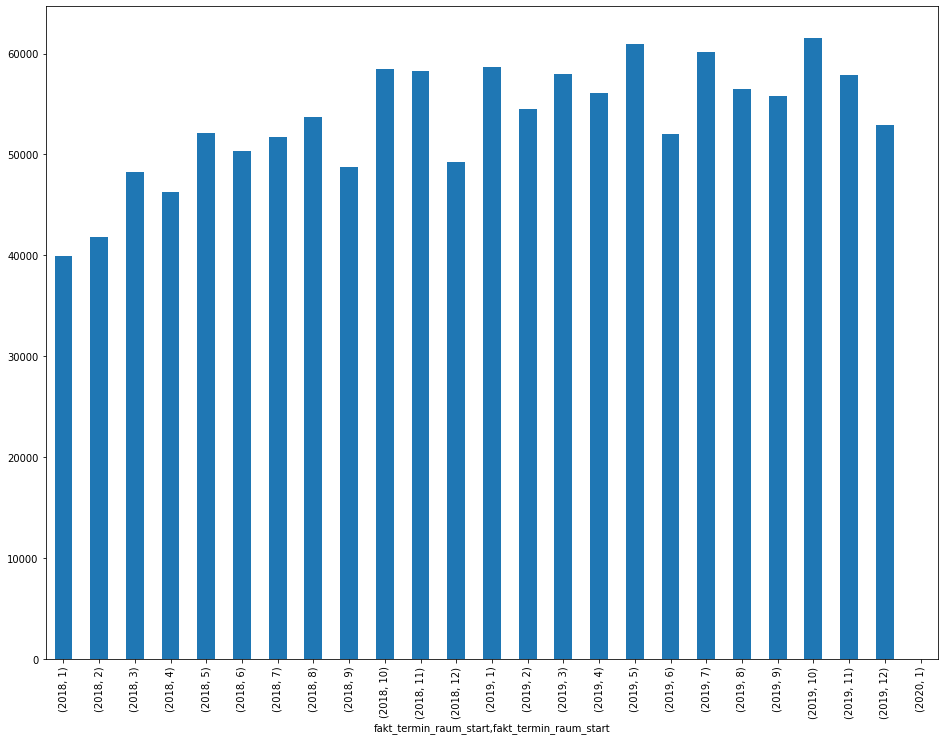

In [32]:
plot_date_histogram_of_col(fact_appointment_room_df, col="fakt_termin_raum_start", by_month=True)

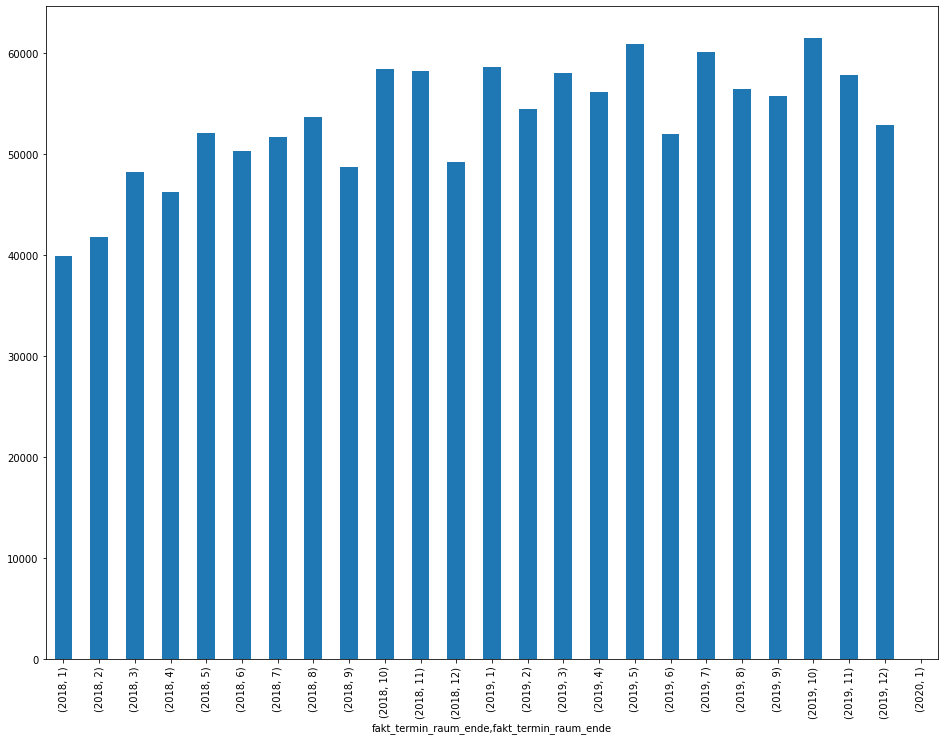

In [33]:
plot_date_histogram_of_col(fact_appointment_room_df, col="fakt_termin_raum_ende", by_month=True)

In [34]:
evaluate_col_classes(fact_appointment_room_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['1945562' '1943324' '10947' ... '988236' '644308' '919200']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['10482046' '10482178' '10366594' ... '9772407' '9757533' '9772466']
CATEGORICAL: Column name: dim_raum_sid, dtype: object, values: ['975' '211' '994' '1293' '992' '1193' '776' '314' '95' '678' '871' '536'
 '649' '149' '166' '102' '35' '191' '427' '1198' '1053' '7' '417' '1164'
 '552' '514' '29' '443' '993' '488' '16' '446' '445' '420' '680' '260'
 '176' '743' '1078' '379' '355' '375' '715' '1036' '515' '150' '1223'
 '669' '421' '138' '855' '833' '561' '1066' '395' '629' '984' '953' '169'
 '982' '511' '1041' '510' '519' '390' '423' '6' '1239' '525' '186' '548'
 '780' '823' '509' '1064' '471' '1189' '460' '293' '1081' '91' '398' '167'
 '177' '428' '481' '670' '559' '373' '1213' '679' '126' '450' '801' '1216'
 '520' '1264' '230' '37' '374' '124' '783' '985' '896' '986' '615' '719'
 '1026' '655' '487

## dd_appointments (Appointments)

In [35]:
dim_appointment_df = pd.read_csv(base_folder + "dd_appointments.csv", dtype=str, parse_dates=["dim_termin_termindatum"])

In [36]:
dim_appointment_df.head(0)

,dim_patient_sid,dim_termin_sid,dim_termin_bk,dim_termin_termintyp,dim_termin_termindatum


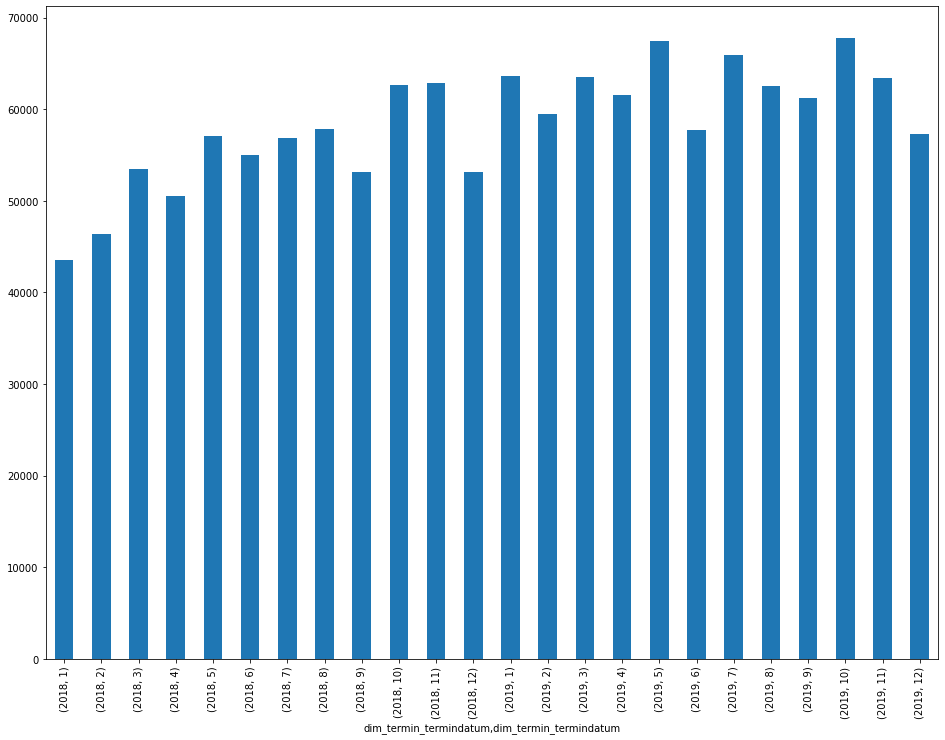

In [37]:
plot_date_histogram_of_col(dim_appointment_df, col="dim_termin_termindatum", by_month=True)

In [38]:
evaluate_col_classes(dim_appointment_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['54175' '729528' '45791' ... '1160974' '1945896' '108093']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['5554340' '5761717' '5636107' ... '11633902' '12070455' '12355444']
CATEGORICAL: Column name: dim_termin_bk, dtype: object, values: ['29368517' '30579613' '29523394' ... '44523941' '44756966' '41906704']
CATEGORICAL: Column name: dim_termin_termintyp, dtype: object, values: ['Patiententermin' 'Gruppentermin' 'Operation']
UNKNOWN: Column name: dim_termin_termindatum, dtype: datetime64[ns], class: numerical


<AxesSubplot:xlabel='stay_counts'>

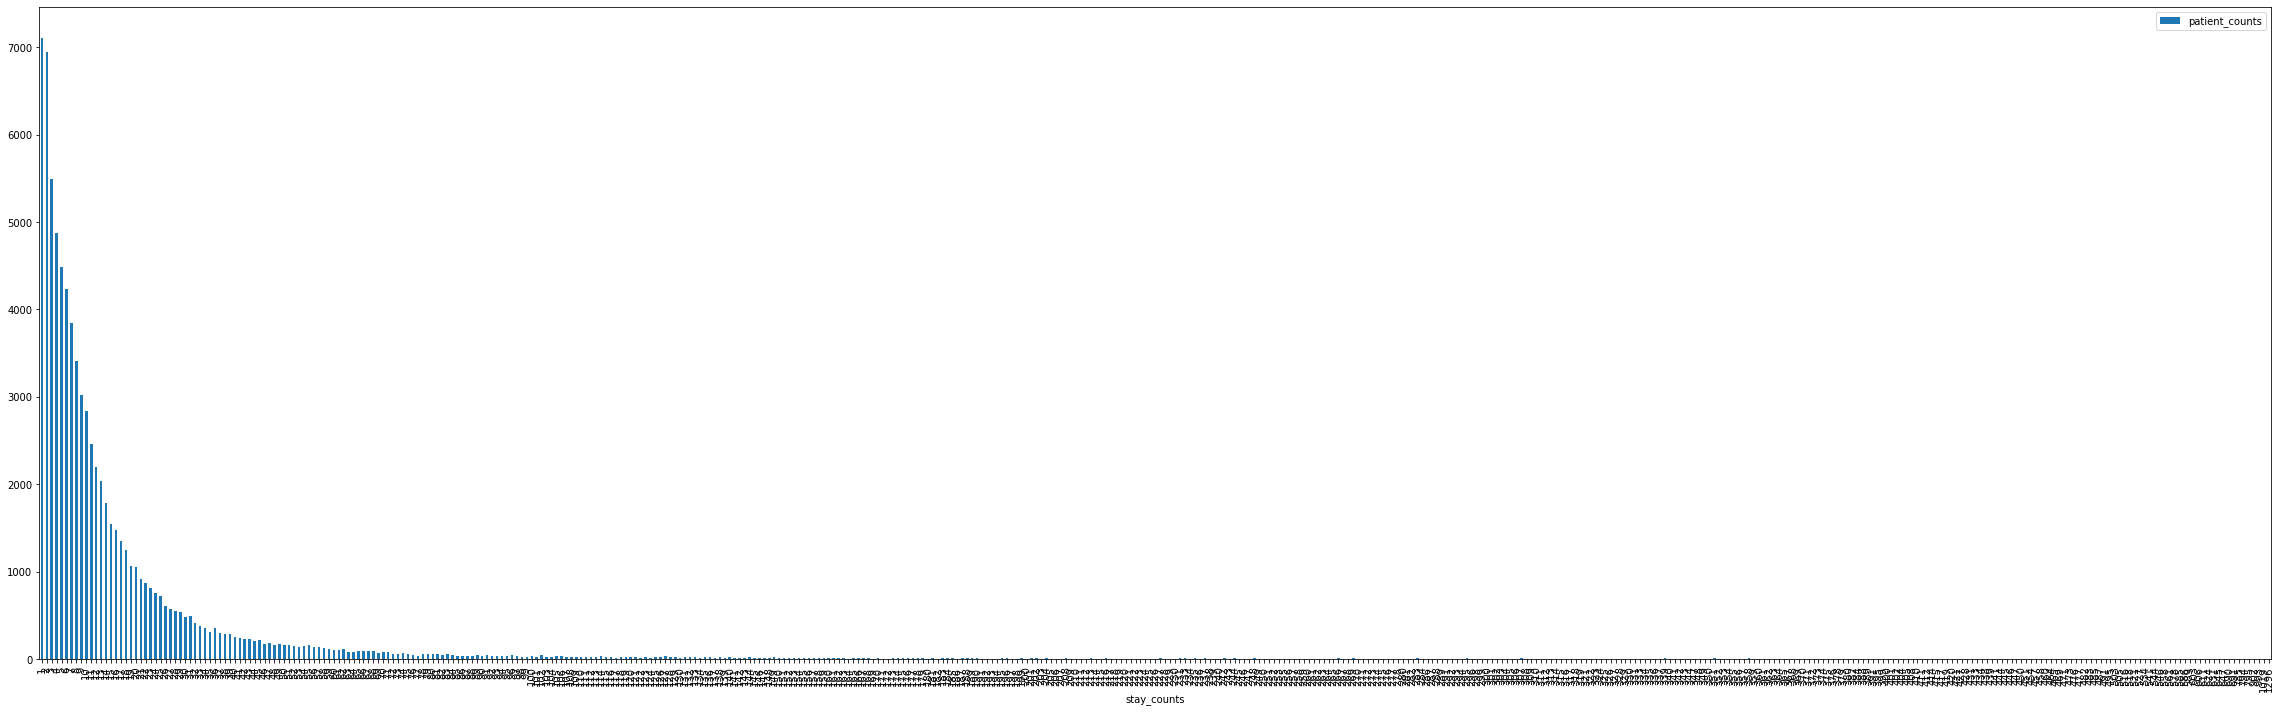

In [39]:
dim_appointment_df.groupby(['dim_patient_sid']).size().reset_index(name='stay_counts').sort_values(by='stay_counts')\
 .groupby(["stay_counts"]).size().reset_index(name='patient_counts').set_index("stay_counts").sort_values(by='stay_counts').plot(kind="bar", figsize=(40,12))

## dd_medications

In [40]:
fact_medication_df = pd.read_csv(base_folder + "dd_medications.csv", dtype=str, parse_dates=["fakt_medikamente_verabreichungsdatum"])

In [41]:
fact_medication_df.head(0)

,dim_patient_sid,dim_patient_bk,dim_fall_bk,dim_atc_bk,fakt_medikamente_verabreichungsdatum


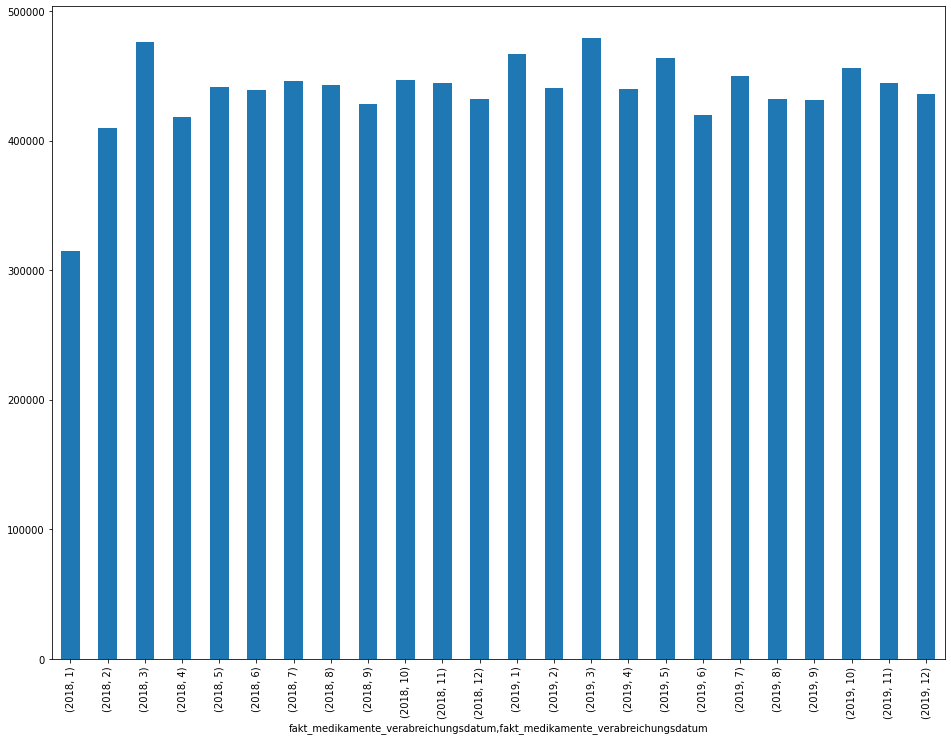

In [42]:
plot_date_histogram_of_col(fact_medication_df, col="fakt_medikamente_verabreichungsdatum", by_month=True)

In [43]:
evaluate_col_classes(fact_medication_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['121117' '28642' '191167' ... '1944258' '1945030' '1945394']
CATEGORICAL: Column name: dim_patient_bk, dtype: object, values: ['00003911985' '00002810409' '00002529947' ... '00015822273' '00015833224'
 '00015836568']
CATEGORICAL: Column name: dim_fall_bk, dtype: object, values: ['0007105303' '0006905243' '0007337335' ... '0007442548' '0007449730'
 '0007452461']
CATEGORICAL: Column name: dim_atc_bk, dtype: object, values: ['B01AB05' 'R01AA07' 'R03BB01' ... 'L03AB11' 'J04AB01' 'J04AK05']
UNKNOWN: Column name: fakt_medikamente_verabreichungsdatum, dtype: datetime64[ns], class: numerical


<AxesSubplot:xlabel='med_counts'>

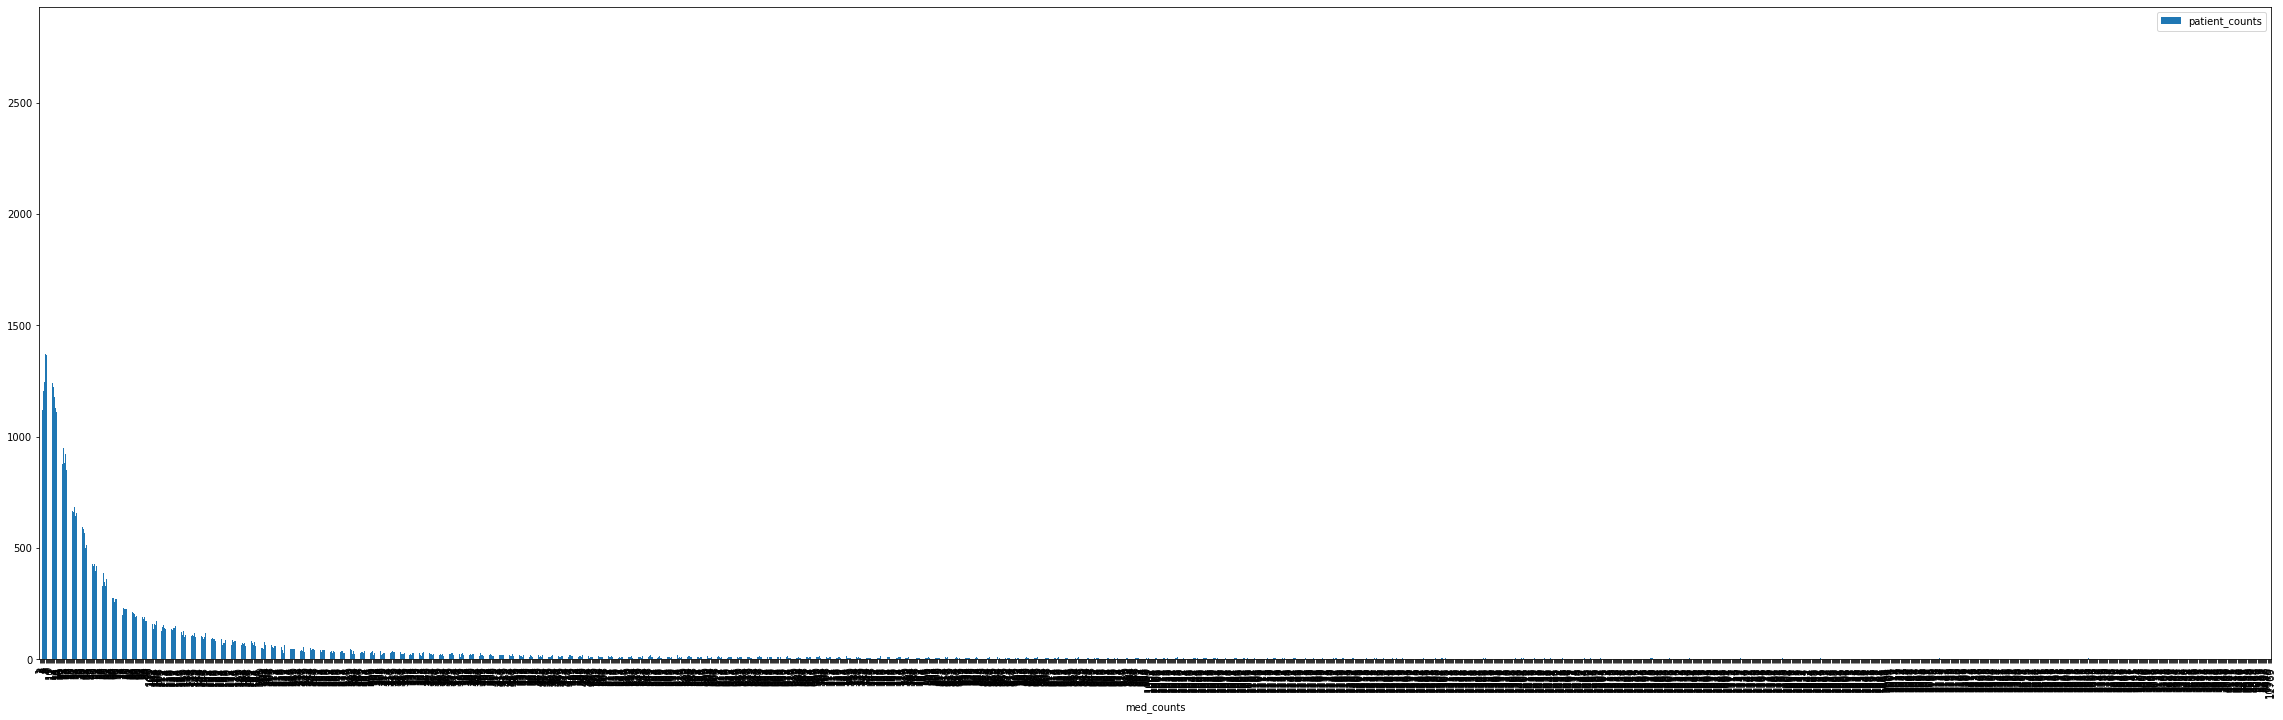

In [44]:
fact_medication_df.groupby(['dim_patient_sid']).size().reset_index(name='med_counts').sort_values(by='med_counts')\
 .groupby(["med_counts"]).size().reset_index(name='patient_counts').set_index("med_counts").sort_values(by='med_counts').plot(kind="bar", figsize=(40,12))

## dd_antibiotics

In [45]:
antibiotics_df = pd.read_csv(base_folder + "dd_antibiotics.csv", dtype=str, parse_dates=["aktion_zeitpunkt"])

In [46]:
antibiotics_df

,dim_patient_sid,dim_patient_bk,verordnung_id,verordnung_datum,medikament_name,medikament_atc,aktionstyp,aktion_zeitpunkt
0,31,00000000353,5345119,2018-03-29,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Modifikation,2018-03-30 06:00:00
1,60,00000000671,5704421,2018-07-02,Cefepime OrPha Trockensub 2 g (Cefepim),J01DE01,Modifikation,2018-07-02 04:00:00
2,88,00000000981,5435623,2018-04-24,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Modifikation,2018-04-24 06:00:00
3,339,00000003794,6149168,2018-10-25,Cefepime OrPha Trockensub 1 g (Cefepim),J01DE01,Modifikation,2018-10-25 02:00:00
4,500,00000005584,5753689,2018-07-14,Co-Amoxi Mepha Trockensub 1.2 g (1'200 mg) (Am...,J01CR02,Modifikation,2018-07-16 08:00:00
...,...,...,...,...,...,...,...,...
124701,1946170,00015844862,7895704,2019-12-30,Cefuroxim Fresenius i.v. Trockensub 750 mg (Ce...,J01DC02,Start,2019-12-30 23:55:00
124702,1946211,00015845273,7896318,2019-12-30,Co-Amoxi Mepha Trockensub 1.2 g (1'200 mg) (Am...,J01CR02,Modifikation,2019-12-30 20:00:00
124703,1946212,00015845281,7896088,2019-12-30,Clindamycin phosphat Pfizer Inj Lös 600 mg/4 m...,J01FF01,Modifikation,2019-12-30 23:55:00
124704,1946217,00015845338,7896499,2019-12-30,Co-Amoxi Mepha Trockensub 2'200 mg (2.2 g) 5 S...,J01CR02,Modifikation,2019-12-30 06:00:00


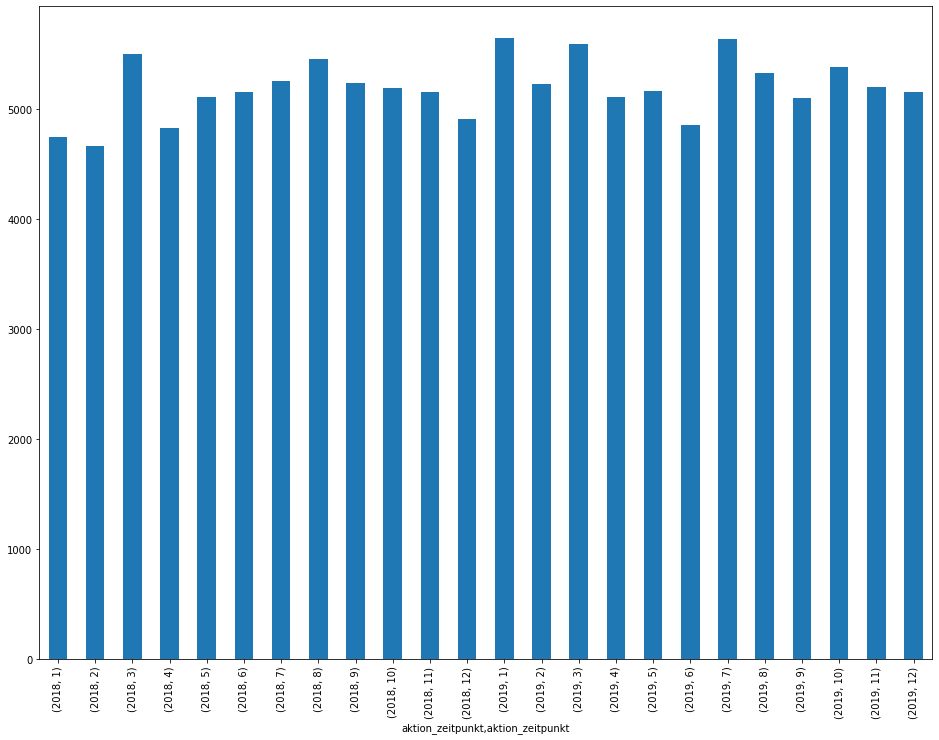

In [47]:
plot_date_histogram_of_col(antibiotics_df, col="aktion_zeitpunkt", by_month=True)

<AxesSubplot:xlabel='antib_counts'>

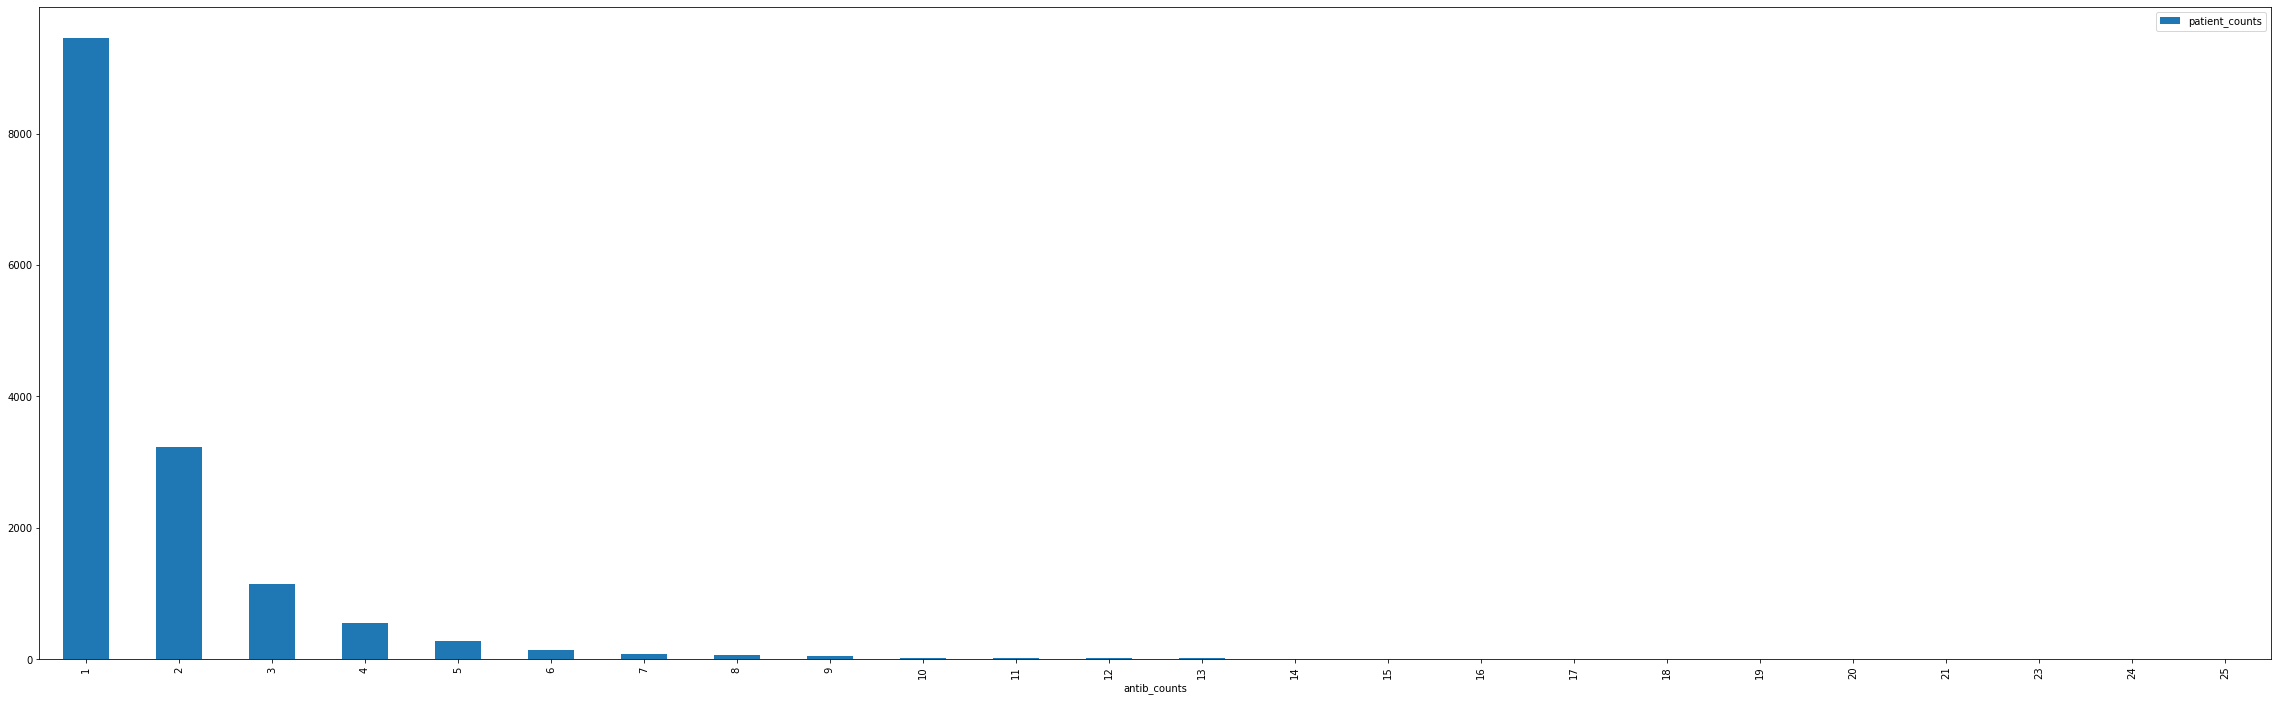

In [48]:
antibiotics_df[antibiotics_df["aktionstyp"] == "Start"].groupby(['dim_patient_sid']).size().reset_index(name='antib_counts').sort_values(by='antib_counts')\
 .groupby(["antib_counts"]).size().reset_index(name='patient_counts').set_index("antib_counts").sort_values(by='antib_counts').plot(kind="bar", figsize=(40,12))

### Median for all patients

In [49]:
extend_by_missing_patients(antibiotics_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    0.0
dtype: float64

## dd_device_contacts (Appointments)

In [50]:
fact_appointment_device_df = pd.read_csv(base_folder + "dd_device_contacts.csv", dtype=str, parse_dates=["fakt_termin_geraet_start", "fakt_termin_geraet_ende"]) #, encoding="ISO-8859-1")

In [51]:
fact_appointment_device_df

,dim_patient_sid,dim_termin_sid,dim_geraet_sid,fakt_termin_geraet_start,fakt_termin_geraet_ende
0,942283,9455944,92,2019-06-27 08:00:00,2019-06-27 08:20:00
1,409428,9458219,672,2019-05-17 08:00:00,2019-05-17 08:15:00
2,1631592,9455545,260,2019-07-15 08:15:00,2019-07-15 08:30:00
3,1631592,9455545,1037,2019-07-15 07:45:00,2019-07-15 08:00:00
4,456954,9454959,997,2019-08-19 08:00:00,2019-08-19 10:00:00
...,...,...,...,...,...
436450,1937808,10321849,827,2019-11-20 11:30:00,2019-11-20 12:30:00
436451,1933915,10321938,210,2019-11-22 08:30:00,2019-11-22 08:45:00
436452,1912297,10322199,119,2019-12-06 14:00:00,2019-12-06 14:30:00
436453,973403,10322283,986,2019-11-28 13:00:00,2019-11-28 13:15:00


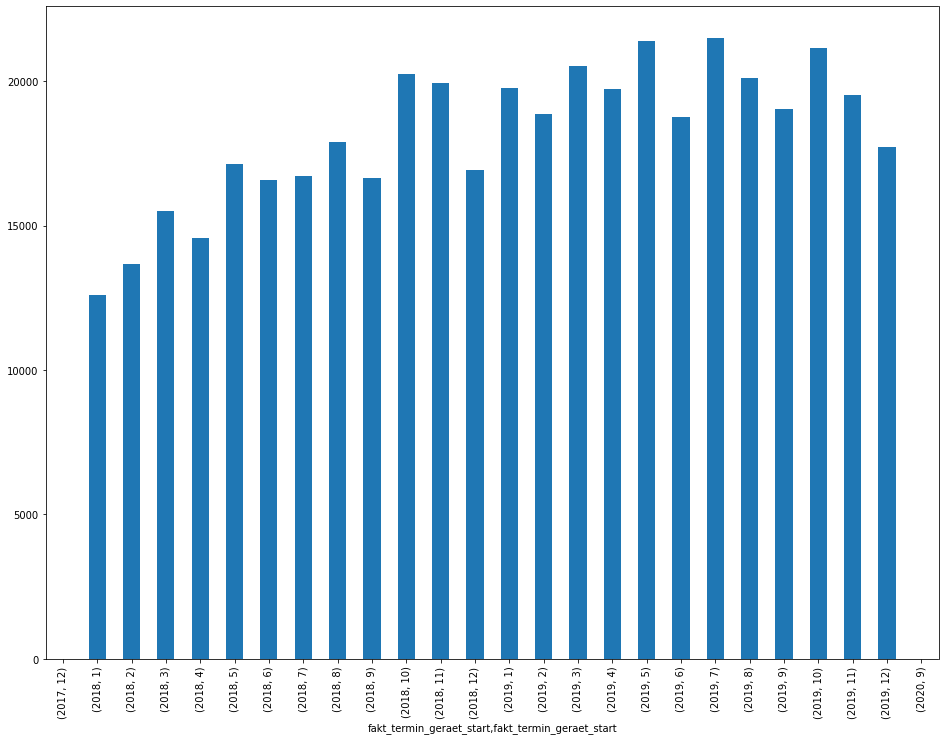

In [52]:
plot_date_histogram_of_col(fact_appointment_device_df, col="fakt_termin_geraet_start", by_month=True)

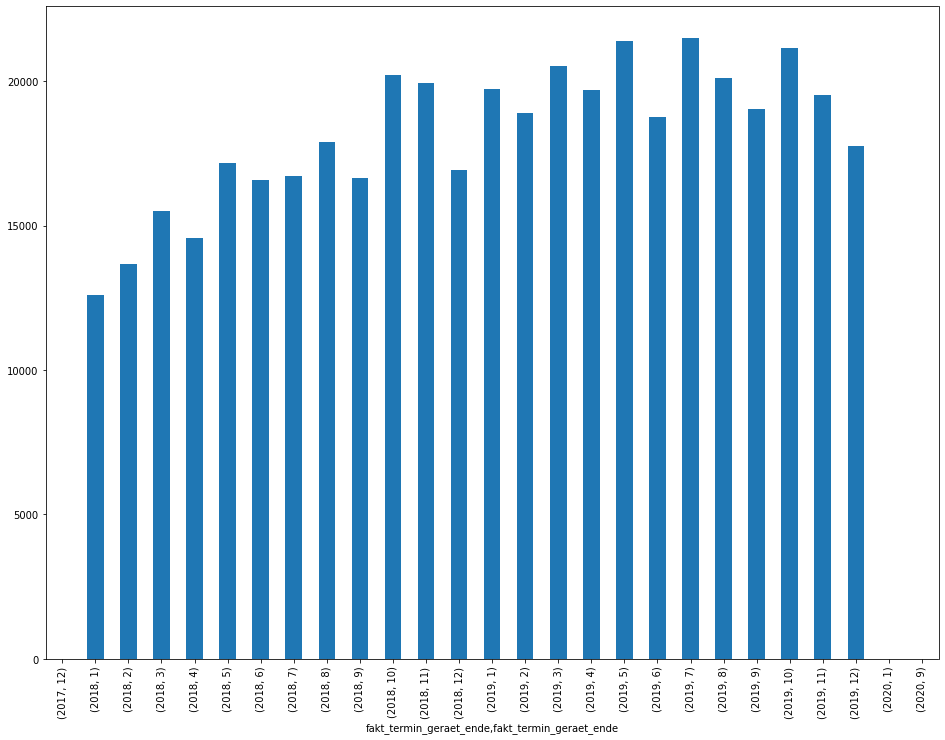

In [53]:
plot_date_histogram_of_col(fact_appointment_device_df, col="fakt_termin_geraet_ende", by_month=True)

In [54]:
evaluate_col_classes(fact_appointment_device_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['942283' '409428' '1631592' ... '1917619' '682291' '1309692']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['9455944' '9458219' '9455545' ... '10322199' '10322283' '10322308']
CATEGORICAL: Column name: dim_geraet_sid, dtype: object, values: ['92' '672' '260' '1037' '997' '122' '136' '577' '166' '97' '17' '1057'
 '816' '496' '1119' '1127' '480' '967' '828' '986' '1008' '1123' '487'
 '521' '250' '150' '156' '709' '703' '565' '488' '103' '832' '157' '1093'
 '766' '707' '1002' '133' '1058' '1060' '861' '191' '96' '90' '261' '519'
 '523' '515' '512' '517' '520' '241' '413' '196' '426' '434' '431' '699'
 '148' '212' '262' '827' '560' '193' '720' '453' '14' '15' '484' '73'
 '671' '1074' '1075' '1080' '183' '1090' '493' '492' '1071' '64' '91'
 '509' '422' '1193' '473' '1135' '121' '128' '320' '511' '751' '116' '78'
 '219' '245' '937' '398' '108' '544' '483' '137' '205' '469' '944' '1148'
 '168' '210' '1091' 

<AxesSubplot:xlabel='device_counts'>

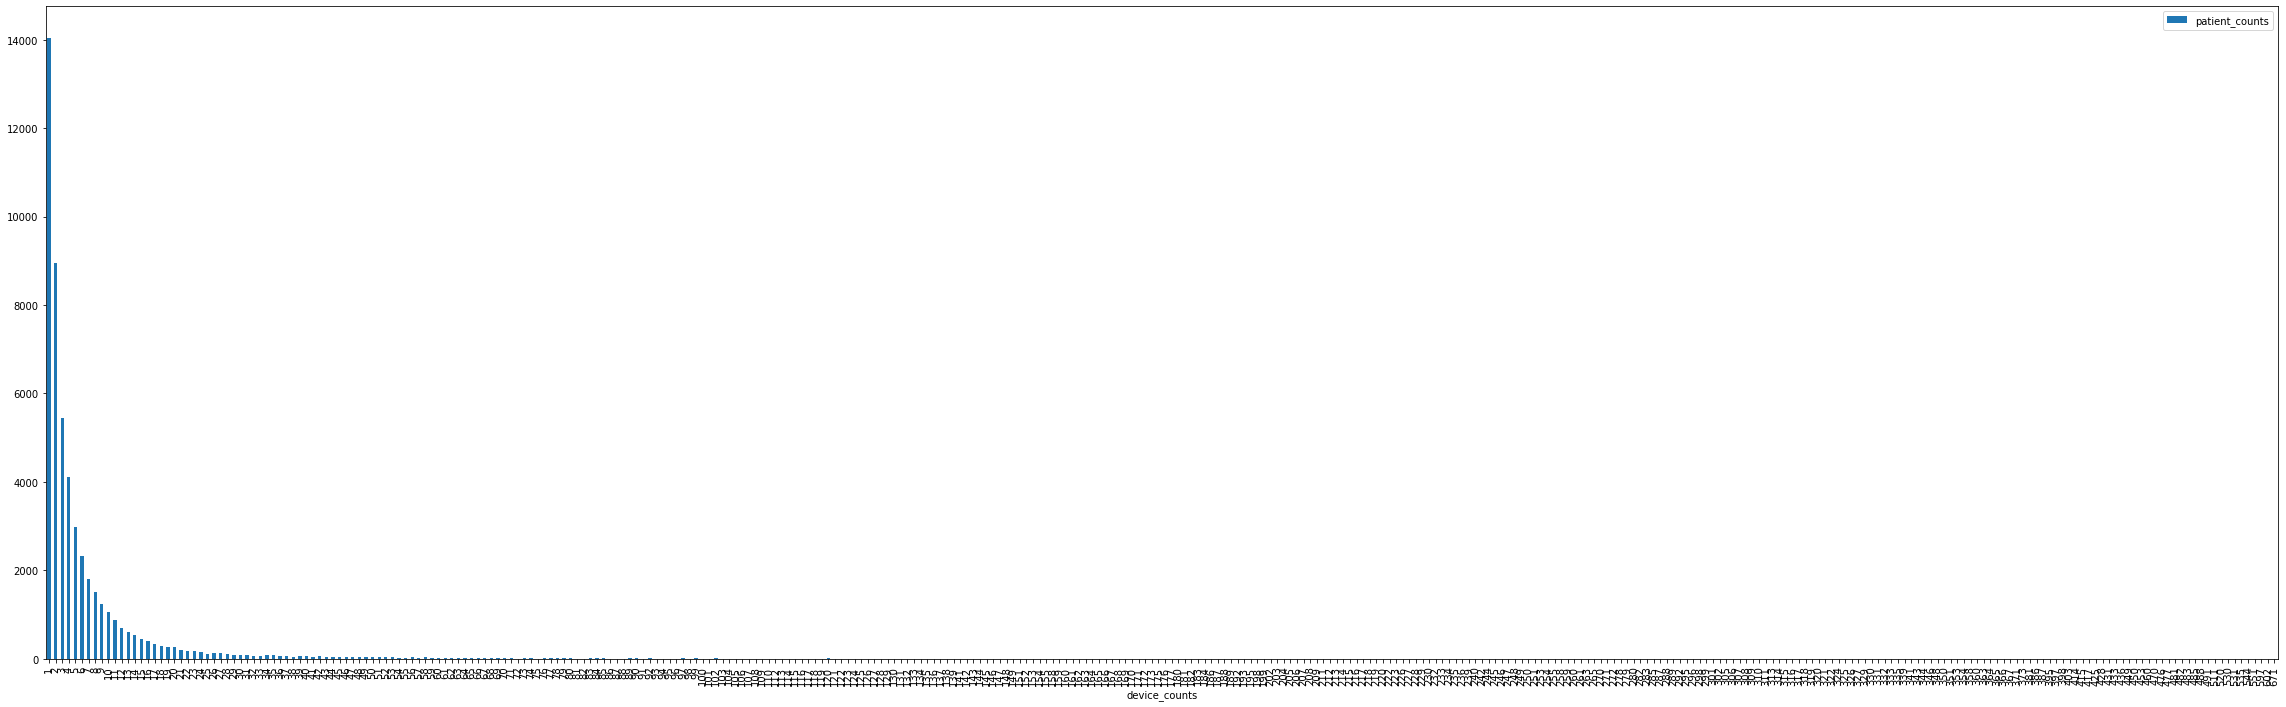

In [55]:
fact_appointment_device_df.groupby(['dim_patient_sid']).size().reset_index(name='device_counts').sort_values(by='device_counts')\
 .groupby(["device_counts"]).size().reset_index(name='patient_counts').set_index("device_counts").sort_values(by='device_counts').plot(kind="bar", figsize=(40,12))

### Median devices of people that have devices

In [56]:
fact_appointment_device_df.groupby(['dim_patient_sid']).size().reset_index(name='device_counts').sort_values(by='device_counts').median()

dim_patient_sid    969895.0
device_counts           3.0
dtype: float64

### Median device for all patients

In [57]:
extend_by_missing_patients(fact_appointment_device_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    0.0
dtype: float64

## dd_employee_contacts (Appointments)

In [58]:
fact_appointment_employee_df = pd.read_csv(base_folder + "dd_employee_contacts.csv", dtype=str, parse_dates=["fakt_termin_mitarbeiter_start", "fakt_termin_mitarbeiter_ende"]) #, encoding="ISO-8859-1")

In [59]:
fact_appointment_employee_df

,dim_patient_sid,dim_termin_sid,dim_mitarbeiter_sid,fakt_termin_mitarbeiter_start,fakt_termin_mitarbeiter_ende
0,738035,8476599,5298,2018-08-16 14:40:00,2018-08-16 15:40:00
1,630450,9888458,16799,2019-10-21 13:00:00,2019-10-21 14:00:00
2,390746,9916011,11565,2019-08-20 10:00:00,2019-08-20 10:30:00
3,1082425,8889797,8687,2019-01-04 12:14:00,2019-01-04 13:42:00
4,539639,9368768,31765,2019-04-11 11:00:00,2019-04-11 11:30:00
...,...,...,...,...,...
1097061,1394832,8149893,17526,2018-04-12 09:00:00,2018-04-12 09:30:00
1097062,323617,8813733,6992,2019-03-04 11:00:00,2019-03-04 11:30:00
1097063,327581,7723575,32473,2018-01-23 10:40:00,2018-01-23 13:07:00
1097064,272535,8683534,16211,2018-11-13 08:17:00,2018-11-13 09:20:00


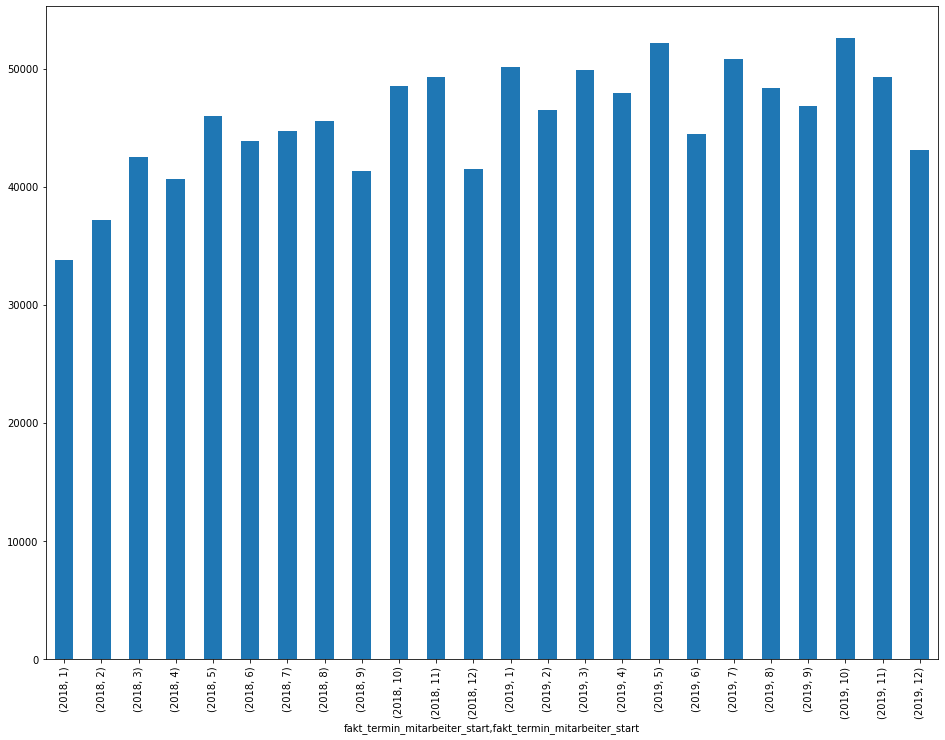

In [60]:
plot_date_histogram_of_col(fact_appointment_employee_df, col="fakt_termin_mitarbeiter_start", by_month=True)

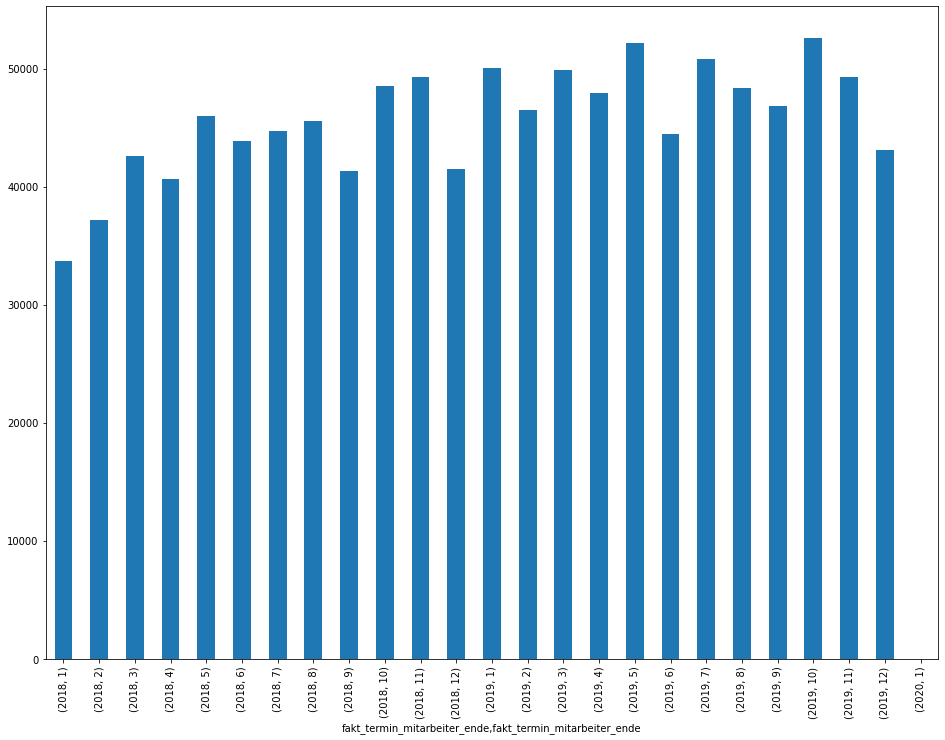

In [61]:
plot_date_histogram_of_col(fact_appointment_employee_df, col="fakt_termin_mitarbeiter_ende", by_month=True)

In [62]:
evaluate_col_classes(fact_appointment_employee_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['738035' '630450' '390746' ... '1058606' '50589' '687102']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['8476599' '9888458' '9916011' ... '8813733' '8683534' '8792448']
CATEGORICAL: Column name: dim_mitarbeiter_sid, dtype: object, values: ['5298' '16799' '11565' ... '33102' '40088' '12720']
UNKNOWN: Column name: fakt_termin_mitarbeiter_start, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: fakt_termin_mitarbeiter_ende, dtype: datetime64[ns], class: numerical


<AxesSubplot:xlabel='emp_counts'>

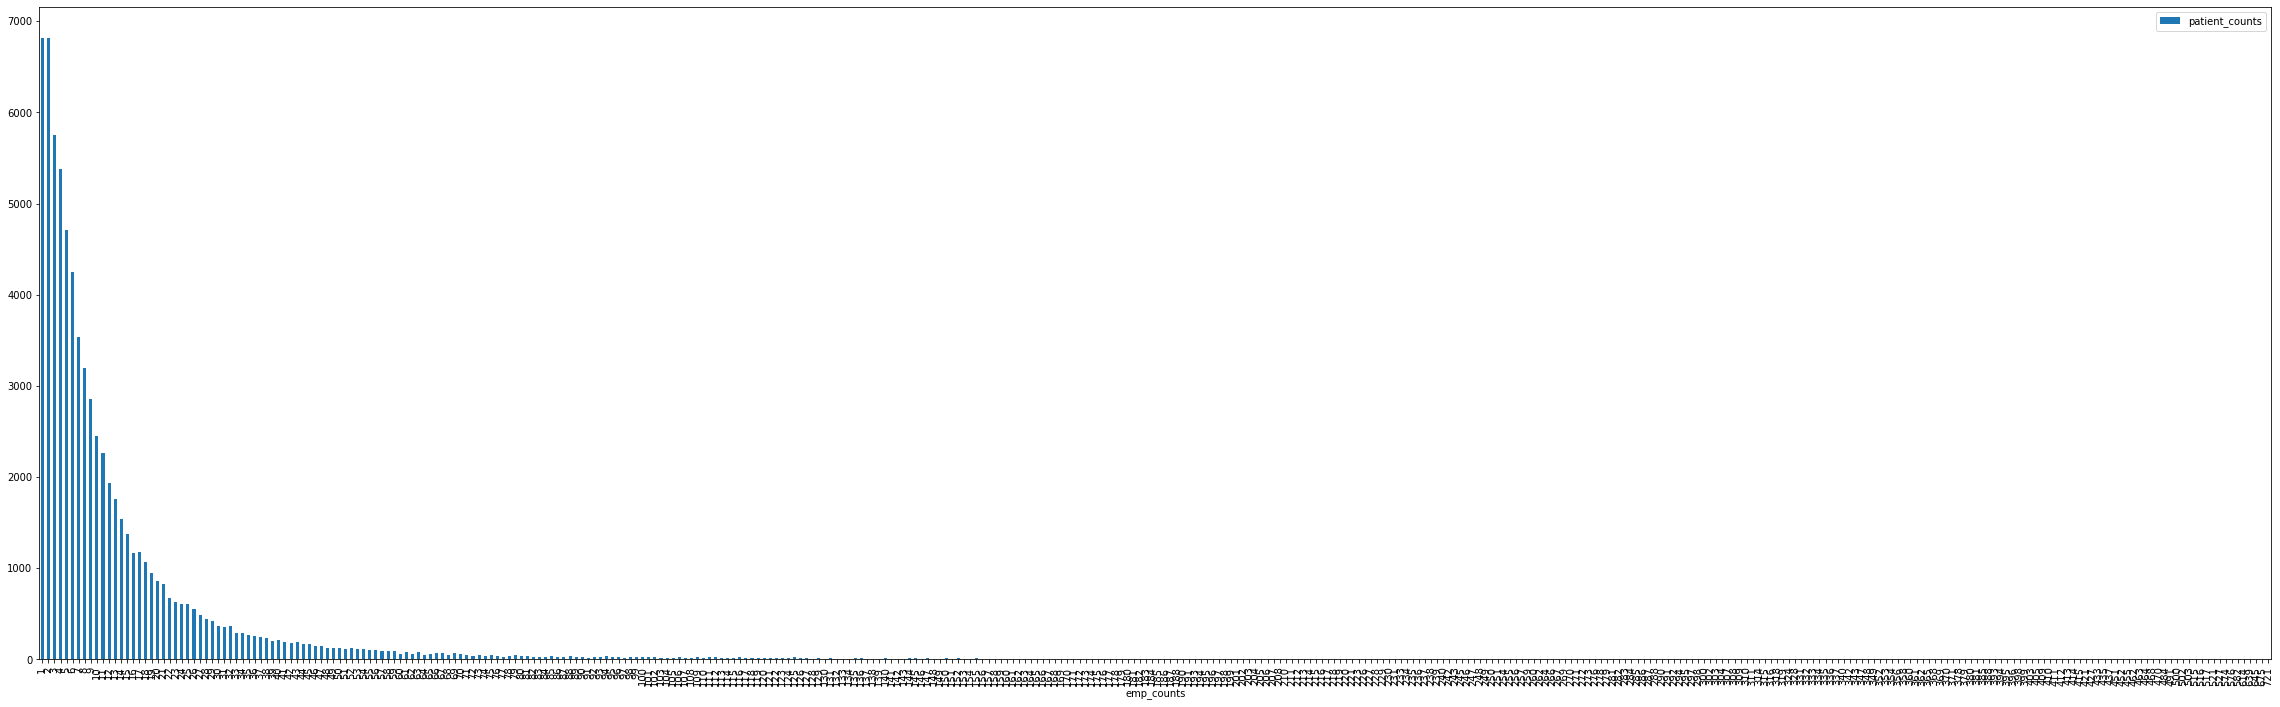

In [63]:
fact_appointment_employee_df.groupby(['dim_patient_sid']).size().reset_index(name='emp_counts').sort_values(by='emp_counts')\
 .groupby(["emp_counts"]).size().reset_index(name='patient_counts').set_index("emp_counts").sort_values(by='emp_counts').plot(kind="bar", figsize=(40,12))

### Median of people that have employee contacts

In [64]:
fact_appointment_employee_df.groupby(['dim_patient_sid']).size().reset_index(name='counts').sort_values(by='counts').median()

dim_patient_sid    976696.0
counts                  7.0
dtype: float64

### Median of all patients

In [65]:
extend_by_missing_patients(fact_appointment_employee_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    4.0
dtype: float64

## dd_room_contacts (Appointments)

In [66]:
fact_appointment_room_df = pd.read_csv(base_folder + "dd_room_contacts.csv", dtype=str, parse_dates=["fakt_termin_raum_start", "fakt_termin_raum_ende"])#, encoding="ISO-8859-1")

In [67]:
fact_appointment_room_df

,dim_patient_sid,dim_termin_sid,dim_raum_sid,fakt_termin_raum_start,fakt_termin_raum_ende
0,1945562,10482046,975,2019-12-31 08:55:00,2019-12-31 09:34:00
1,1943324,10482178,211,2019-12-31 07:00:00,2019-12-31 08:00:00
2,10947,10366594,994,2019-12-02 14:00:00,2019-12-02 14:30:00
3,1459122,10366612,1293,2019-12-19 09:00:00,2019-12-19 09:30:00
4,1459122,10366612,992,2019-12-19 10:10:00,2019-12-19 10:25:00
...,...,...,...,...,...
1284009,1105646,9772273,387,2019-09-12 10:00:00,2019-09-12 11:00:00
1284010,1352693,9772284,420,2019-07-30 11:00:00,2019-07-30 11:15:00
1284011,1377220,9772407,1143,2019-07-11 12:00:00,2019-07-11 15:20:00
1284012,1912355,9757533,871,2019-07-11 14:30:00,2019-07-11 15:30:00


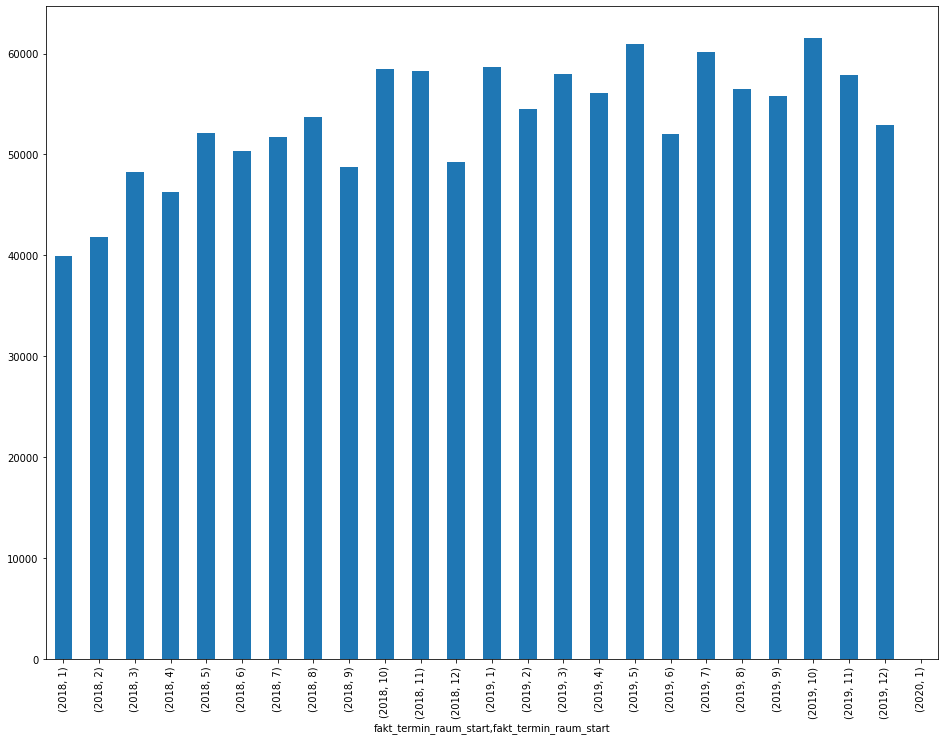

In [68]:
plot_date_histogram_of_col(fact_appointment_room_df, col="fakt_termin_raum_start", by_month=True)

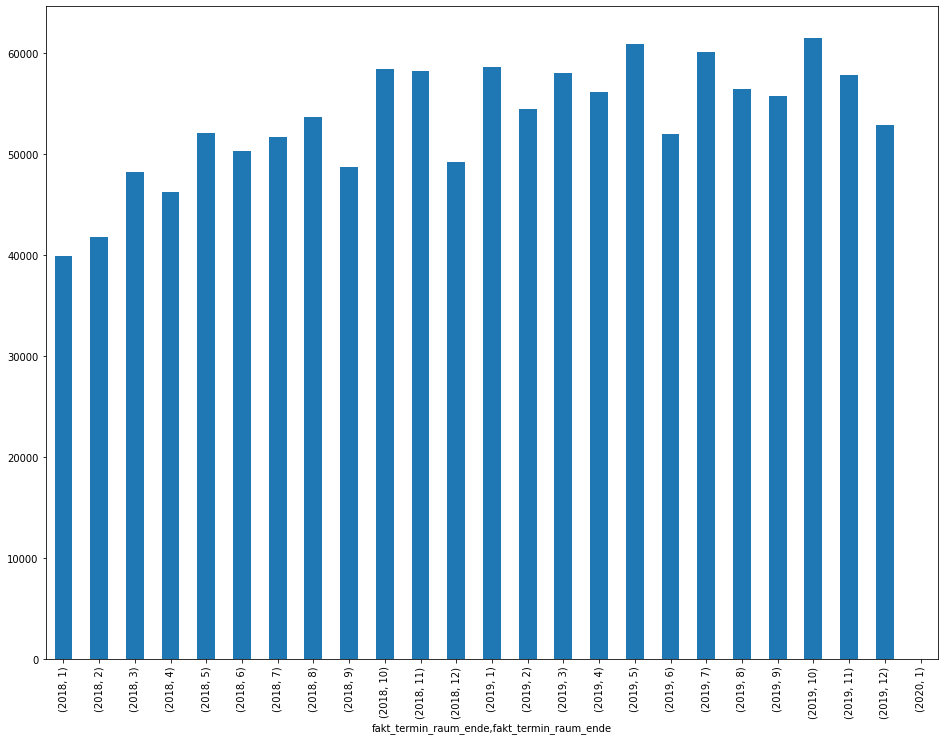

In [69]:
plot_date_histogram_of_col(fact_appointment_room_df, col="fakt_termin_raum_ende", by_month=True)

In [70]:
evaluate_col_classes(fact_appointment_room_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['1945562' '1943324' '10947' ... '988236' '644308' '919200']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['10482046' '10482178' '10366594' ... '9772407' '9757533' '9772466']
CATEGORICAL: Column name: dim_raum_sid, dtype: object, values: ['975' '211' '994' '1293' '992' '1193' '776' '314' '95' '678' '871' '536'
 '649' '149' '166' '102' '35' '191' '427' '1198' '1053' '7' '417' '1164'
 '552' '514' '29' '443' '993' '488' '16' '446' '445' '420' '680' '260'
 '176' '743' '1078' '379' '355' '375' '715' '1036' '515' '150' '1223'
 '669' '421' '138' '855' '833' '561' '1066' '395' '629' '984' '953' '169'
 '982' '511' '1041' '510' '519' '390' '423' '6' '1239' '525' '186' '548'
 '780' '823' '509' '1064' '471' '1189' '460' '293' '1081' '91' '398' '167'
 '177' '428' '481' '670' '559' '373' '1213' '679' '126' '450' '801' '1216'
 '520' '1264' '230' '37' '374' '124' '783' '985' '896' '986' '615' '719'
 '1026' '655' '487

<AxesSubplot:xlabel='room_counts'>

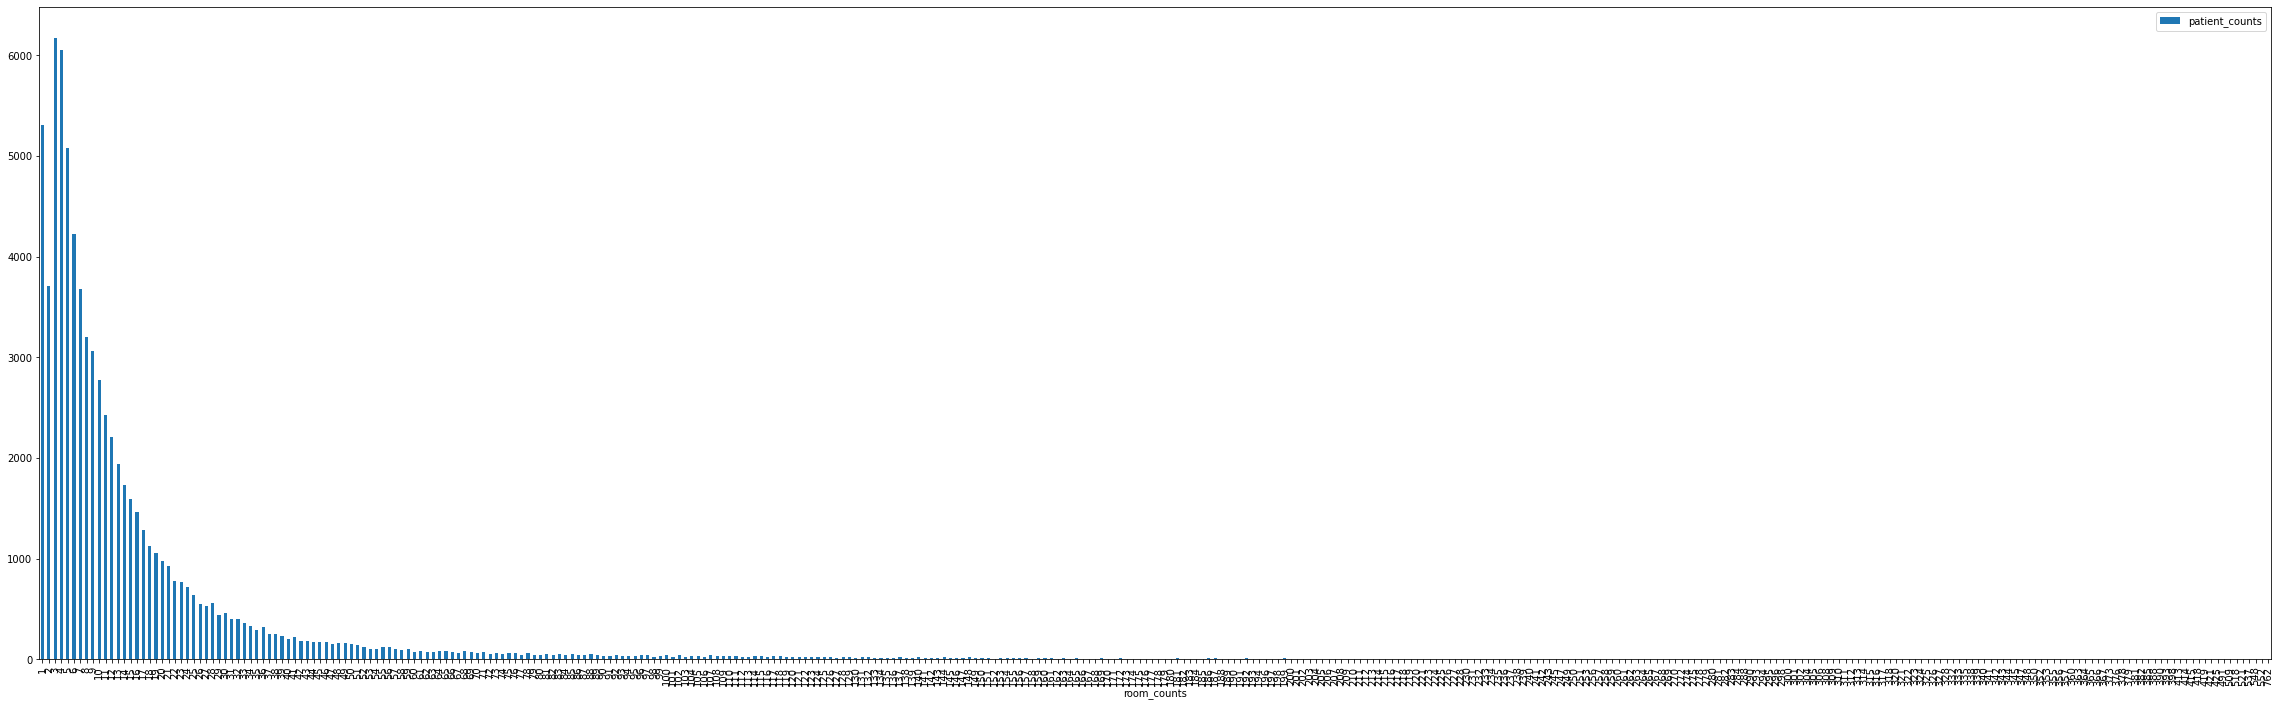

In [71]:
fact_appointment_room_df.groupby(['dim_patient_sid']).size().reset_index(name='room_counts').sort_values(by='room_counts')\
 .groupby(["room_counts"]).size().reset_index(name='patient_counts').set_index("room_counts").sort_values(by='room_counts').plot(kind="bar", figsize=(40,12))

### Median of people that have room contacts

In [72]:
fact_appointment_room_df.groupby(['dim_patient_sid']).size().reset_index(name='counts').sort_values(by='counts').median()

dim_patient_sid    980179.0
counts                  9.0
dtype: float64

### Median of all patients

In [73]:
extend_by_missing_patients(fact_appointment_room_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    5.0
dtype: float64

## dd_room_stays (Stays/Bewegungen)

In [74]:
fact_appointment_room_stays_df = pd.read_csv(base_folder + "dd_room_stays.csv", dtype=str, parse_dates=["fakt_patient_bewegung_date"])#, encoding="ISO-8859-1")

In [75]:
fact_appointment_room_stays_df

,dim_patient_sid,dim_fall_sid,fakt_patient_bewegung_zimmer,fakt_patient_bewegung_class,fakt_patient_bewegung_date
0,708357,4648667,NaN,NaN,2018-02-15 16:00:00
1,347249,4625425,NaN,NaN,2018-04-10 09:00:00
2,1634044,6410974,NaN,NaN,2019-01-31 10:00:00
3,1282548,6383553,00061332,0003,2019-01-10 11:25:04
4,1638806,6441802,KK KN211,0003,2019-02-12 10:05:00
...,...,...,...,...,...
1723750,588779,6755711,NaN,NaN,2019-07-22 08:11:00
1723751,9055,6751170,NaN,NaN,2019-08-09 16:11:00
1723752,470937,6751176,NaN,NaN,2019-07-17 07:24:00
1723753,1919659,6767232,NaN,NaN,2019-08-16 15:23:00


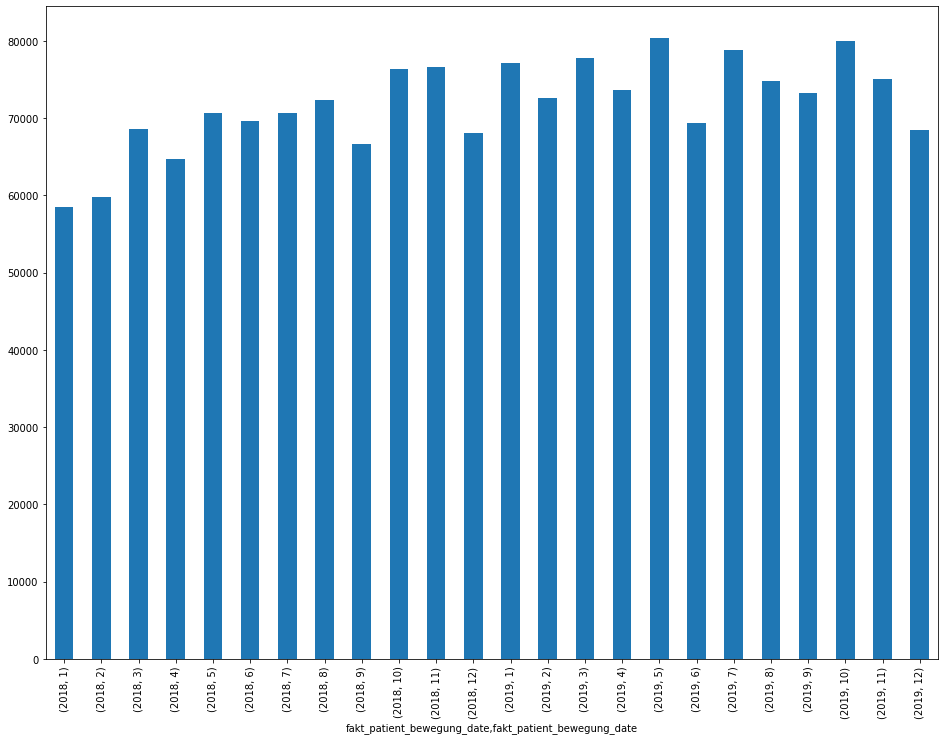

In [76]:
plot_date_histogram_of_col(fact_appointment_room_stays_df, col="fakt_patient_bewegung_date", by_month=True)

In [77]:
evaluate_col_classes(fact_appointment_room_stays_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['708357' '347249' '1634044' ... '13553' '814649' '331305']
CATEGORICAL: Column name: dim_fall_sid, dtype: object, values: ['4648667' '4625425' '6410974' ... '6751176' '6767232' '6774550']
CATEGORICAL: Column name: fakt_patient_bewegung_zimmer, dtype: object, values: [nan '00061332' 'KK KN211' ... '64ABG11' 'BAD U2' '64AB103']
CATEGORICAL: Column name: fakt_patient_bewegung_class, dtype: object, values: [nan '0003' '0002' '0001' '3/1' '3/2' '2/3' '2/1' '1/3' '1/2']
UNKNOWN: Column name: fakt_patient_bewegung_date, dtype: datetime64[ns], class: numerical


<AxesSubplot:xlabel='room_counts'>

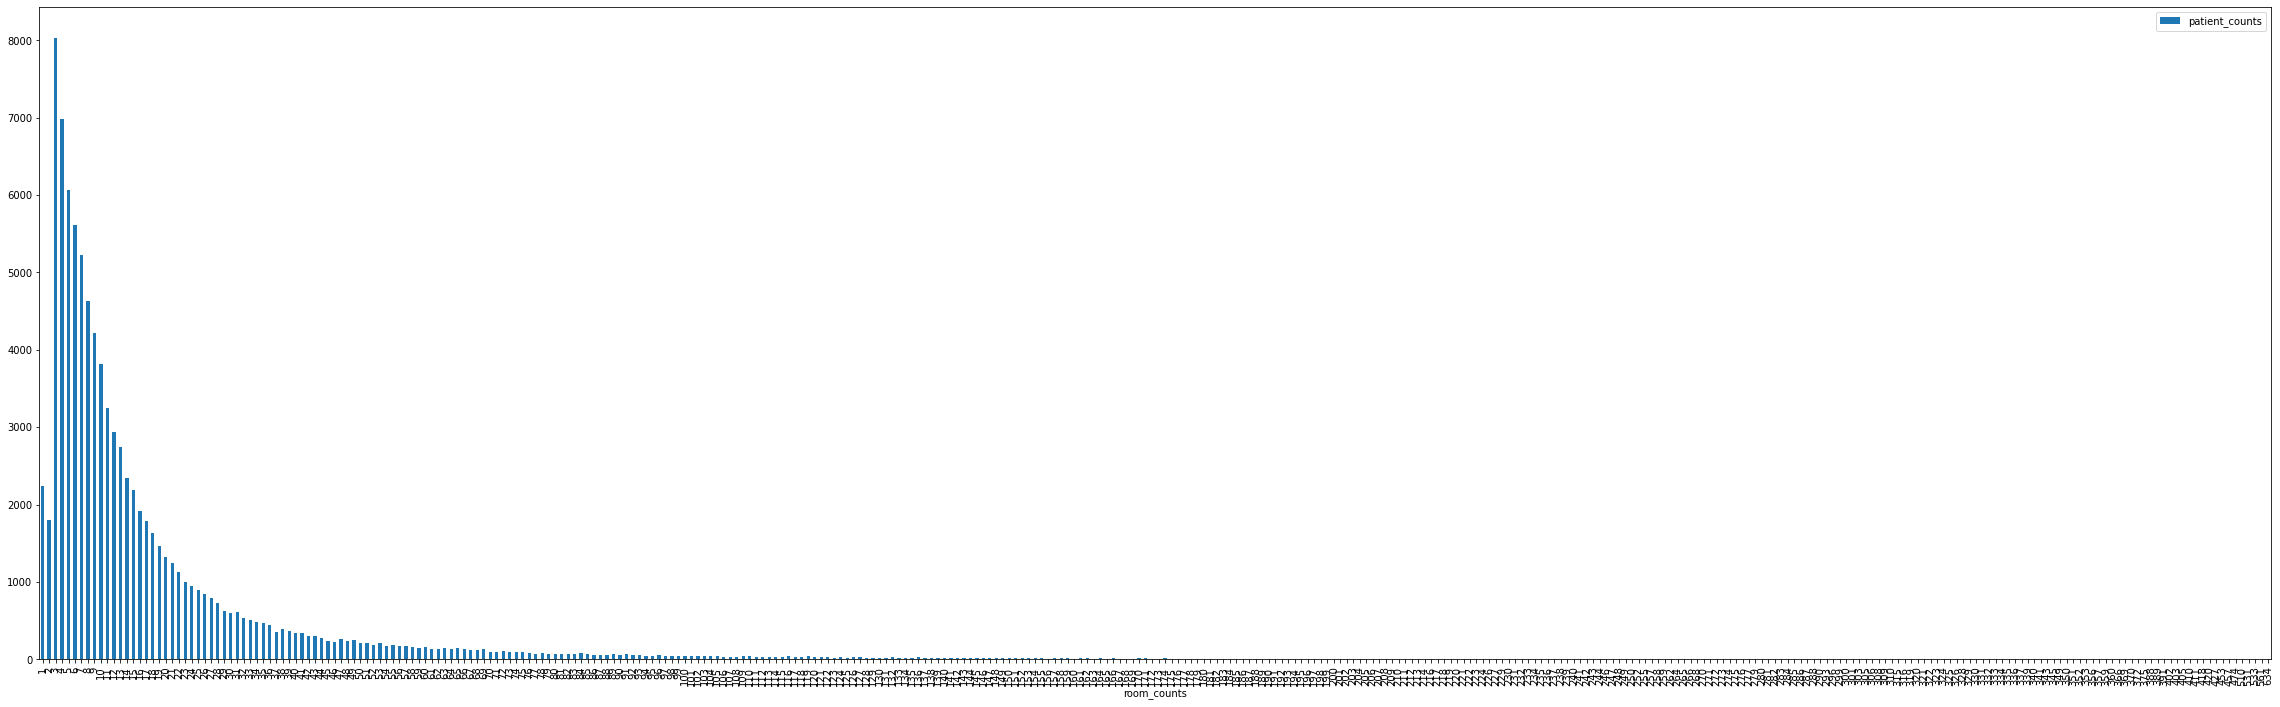

In [78]:
fact_appointment_room_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='room_counts').sort_values(by='room_counts')\
 .groupby(["room_counts"]).size().reset_index(name='patient_counts').set_index("room_counts").sort_values(by='room_counts').plot(kind="bar", figsize=(40,12))

### Median of people that have room stays

In [79]:
fact_appointment_room_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='counts').sort_values(by='counts').median()

dim_patient_sid    1035425.5
counts                  10.0
dtype: float64

### Median of all patients

In [80]:
extend_by_missing_patients(fact_appointment_room_stays_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    8.0
dtype: float64

## dd_surgery_chops

### TODO: DEDUPLICATE CHOPS

In [81]:
chop_surgical_procedures_code_df = pd.read_csv(base_folder + "dd_surgery_chops.csv", parse_dates=['date'])#, encoding="ISO-8859-1")

In [82]:
chop_surgical_procedures_code_df

,chop_code,date,case_id
0,51.23,2018-02-21,6367577
1,51.23,2018-02-21,6367577
2,51.88,2018-02-21,6367577
3,51.88,2018-02-21,6367577
4,51.85,2018-02-21,6367577
...,...,...,...
1748878,AA.11.14,2019-08-09,7178210
1748879,AA.11.14,2019-08-09,7178210
1748880,AA.21.15,2019-07-05,7178210
1748881,AA.21.15,2019-07-05,7178210


In [83]:
unique_chop_surgical_procedures_code_df = chop_surgical_procedures_code_df.drop_duplicates()

In [84]:
unique_chop_surgical_procedures_code_df

,chop_code,date,case_id
0,51.23,2018-02-21,6367577
2,51.88,2018-02-21,6367577
4,51.85,2018-02-21,6367577
6,51.95.10,2018-02-21,6367577
8,96.6,2018-01-31,6358809
...,...,...,...
1748858,BA.1,2019-07-21,7178086
1748866,93.19,2019-07-21,7178086
1748874,AA.11.13,2019-07-05,7178210
1748877,AA.11.14,2019-08-09,7178210


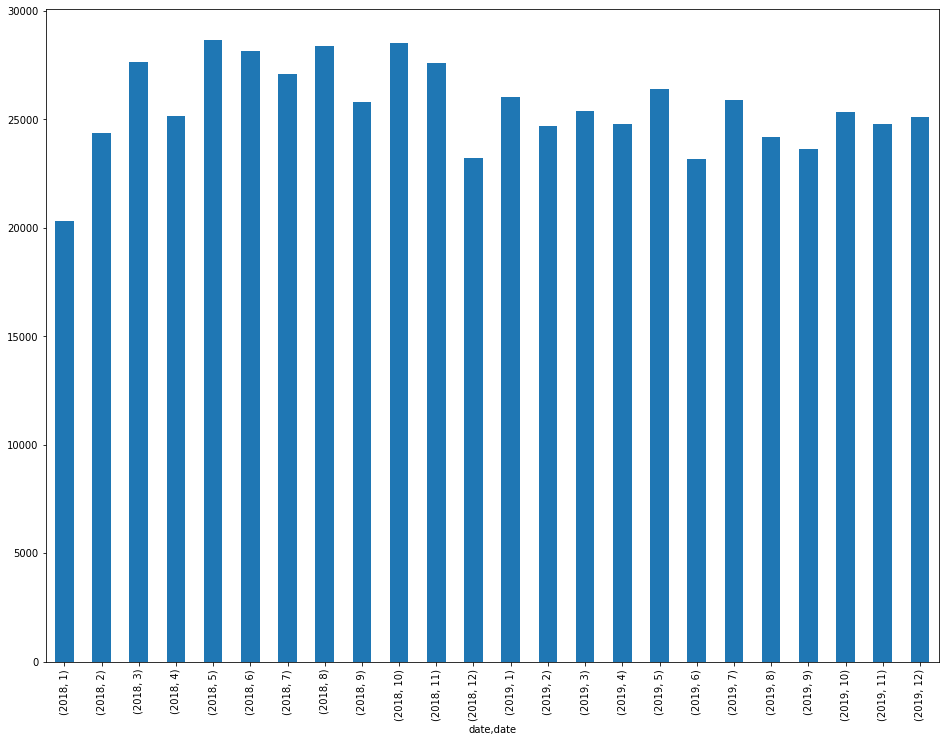

In [85]:
plot_date_histogram_of_col(unique_chop_surgical_procedures_code_df, col="date", by_month=True)

In [86]:
evaluate_col_classes(unique_chop_surgical_procedures_code_df)

CATEGORICAL: Column name: chop_code, dtype: object, values: ['51.23' '51.88' '51.85' ... '39.95.E5' '34.23.99' '31.94']
UNKNOWN: Column name: date, dtype: datetime64[ns], class: numerical
NUMERICAL: Column name: case_id, dtype: int64, #qty unique values: 109265


<AxesSubplot:xlabel='chop_counts'>

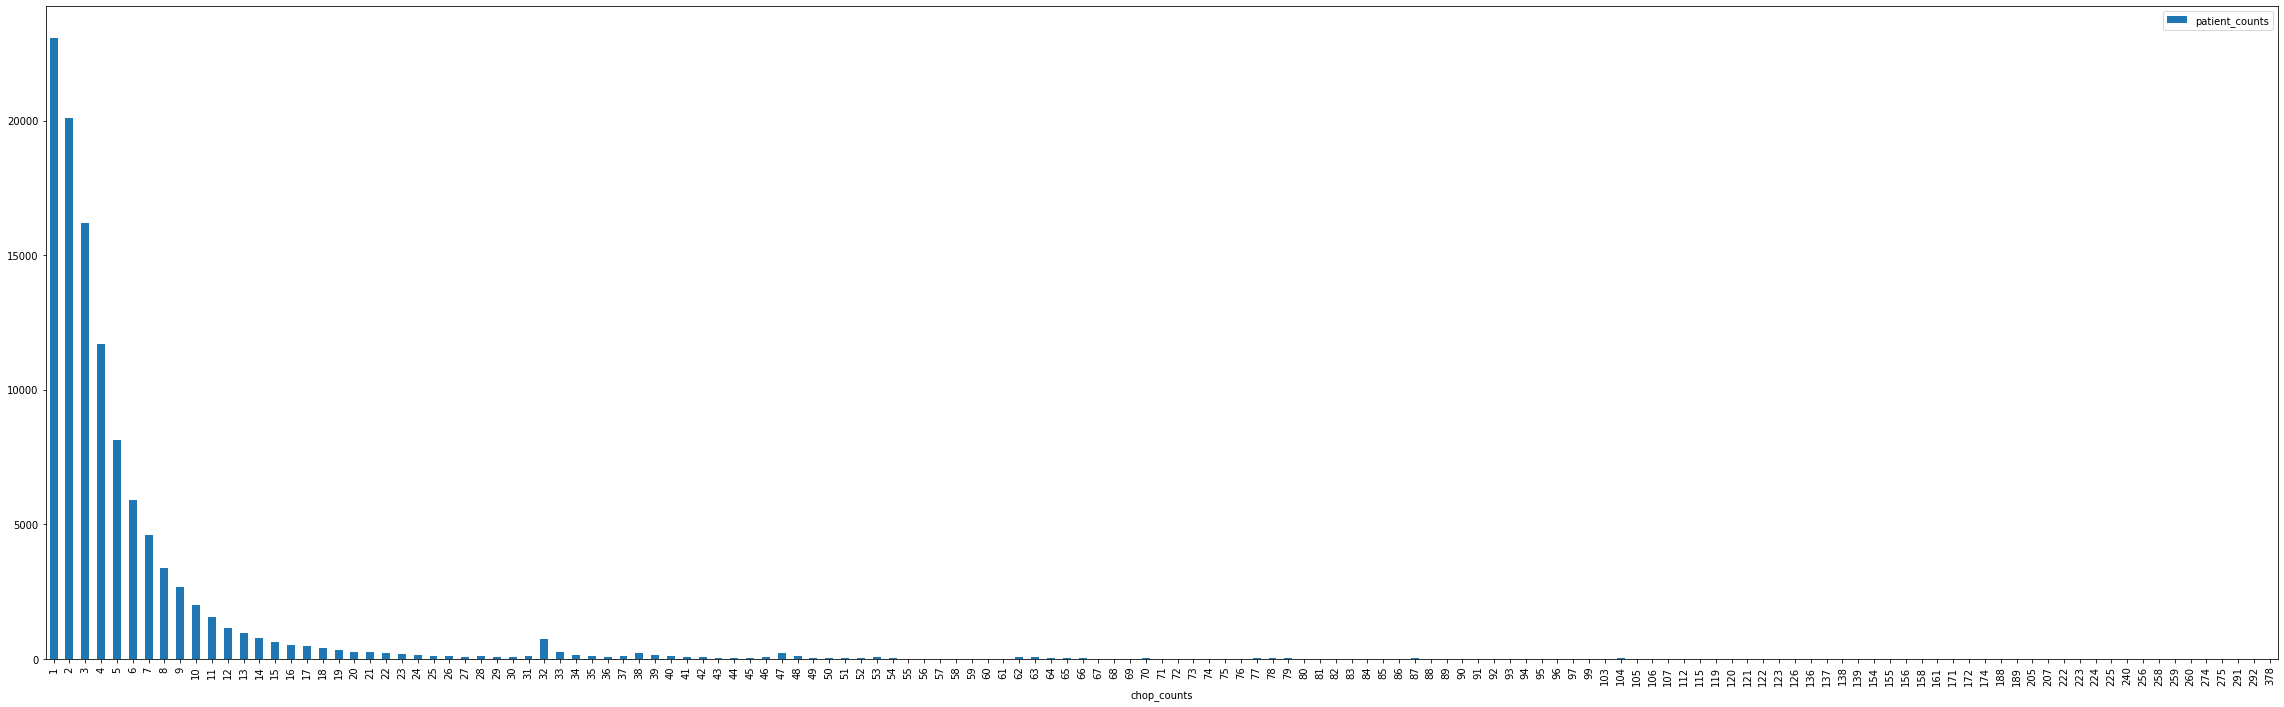

In [87]:
unique_chop_surgical_procedures_code_df.groupby(['case_id']).size().reset_index(name='chop_counts').sort_values(by='chop_counts')\
 .groupby(["chop_counts"]).size().reset_index(name='patient_counts').set_index("chop_counts").sort_values(by='chop_counts').plot(kind="bar", figsize=(40,12))

## dd_surgery_appointments

In [88]:
surgery_appointments_df = pd.read_csv(base_folder + "dd_surgery_appointments.csv", parse_dates=['dim_termin_termindatum'], dtype='str')#, encoding="ISO-8859-1")

In [89]:
surgery_appointments_df

,dim_patient_sid,dim_termin_sid,dim_termin_bk,dim_termin_termintyp,dim_termin_termindatum
0,130148,7409303,37014469,Operation,2018-01-08
1,865094,7706968,38082323,Operation,2018-01-09
2,1258846,7730951,38082809,Operation,2018-02-09
3,555776,7730952,38082818,Operation,2018-01-15
4,261259,7802847,38084068,Operation,2018-01-26
...,...,...,...,...,...
122073,818550,10532435,45162998,Operation,2019-12-31
122074,1133167,10618221,45352699,Operation,2019-12-27
122075,1944979,10618556,45353231,Operation,2019-12-21
122076,1385350,10639362,45406063,Operation,2019-12-05


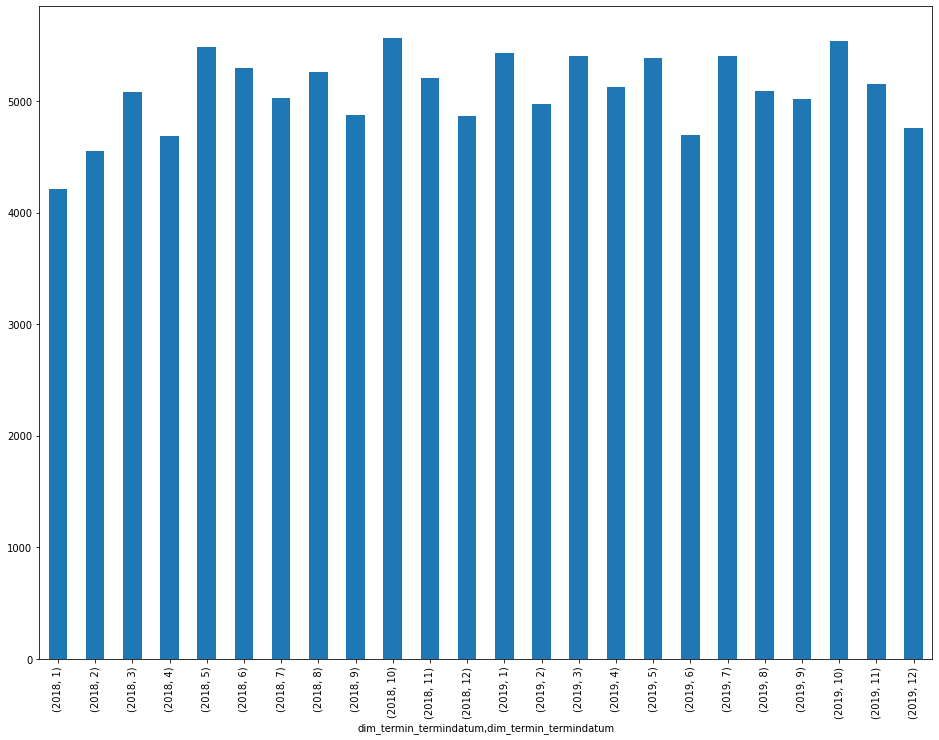

In [90]:
plot_date_histogram_of_col(surgery_appointments_df, col="dim_termin_termindatum", by_month=True)

<AxesSubplot:xlabel='surgery_counts'>

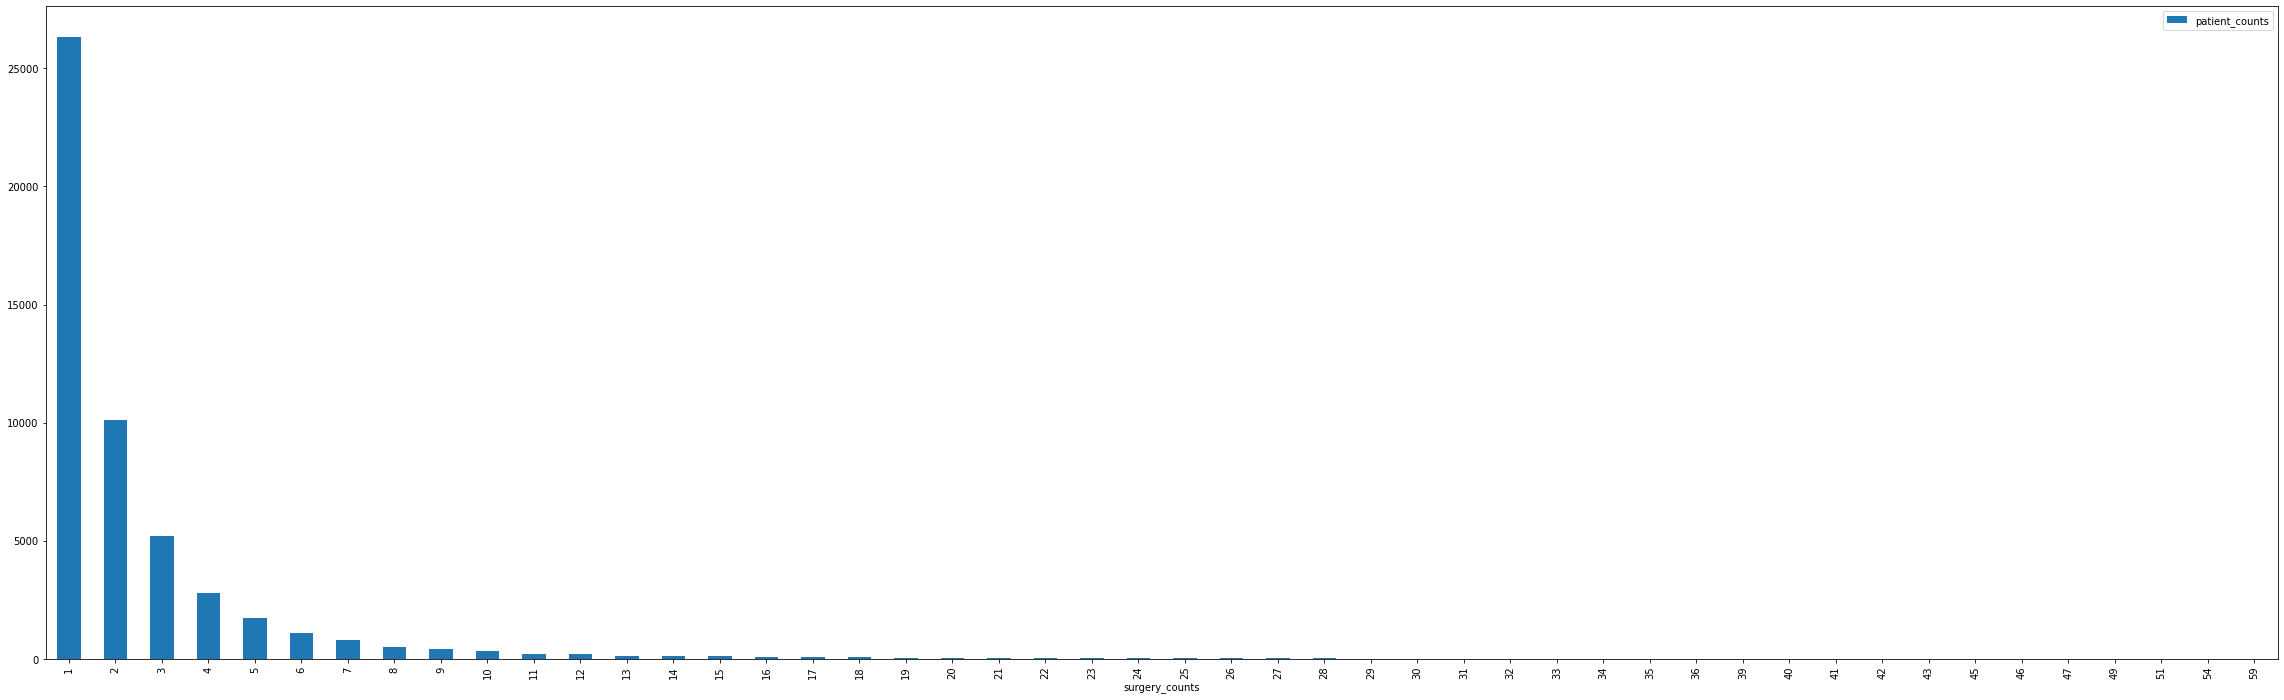

In [91]:
surgery_appointments_df.groupby(['dim_patient_sid']).size().reset_index(name='surgery_counts').sort_values(by='surgery_counts')\
 .groupby(["surgery_counts"]).size().reset_index(name='patient_counts').set_index("surgery_counts").sort_values(by='surgery_counts').plot(kind="bar", figsize=(40,12))

### Median of people that have surgeries

In [92]:
surgery_appointments_df.groupby(['dim_patient_sid']).size().reset_index(name='surgery_counts').sort_values(by='surgery_counts').median()

dim_patient_sid    1010432.5
surgery_counts           1.0
dtype: float64

### Median of all patients

In [93]:
extend_by_missing_patients(surgery_appointments_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
counts                    0.0
dtype: float64

In [94]:
evaluate_col_classes(surgery_appointments_df)

CATEGORICAL: Column name: dim_patient_sid, dtype: object, values: ['130148' '865094' '1258846' ... '1934664' '1133167' '640746']
CATEGORICAL: Column name: dim_termin_sid, dtype: object, values: ['7409303' '7706968' '7730951' ... '10618556' '10639362' '10639497']
CATEGORICAL: Column name: dim_termin_bk, dtype: object, values: ['37014469' '38082323' '38082809' ... '45353231' '45406063' '45406336']
CATEGORICAL: Column name: dim_termin_termintyp, dtype: object, values: ['Operation']
UNKNOWN: Column name: dim_termin_termindatum, dtype: datetime64[ns], class: numerical


## dd_ICD-10 Codes

In [139]:
icd10_codes_df = pd.read_csv(base_folder + "dd_icd10_codes.csv", parse_dates=['DIADT'], dtype='str')

In [140]:
icd10_codes_df

,CASEID,dim_patient_sid,dim_fall_patient_bk,DKEY1,DIADT
0,0006496413,1105917,00014608111,J32.4,2018-05-04
1,0006496413,1105917,00014608111,R43.0,2018-05-04
2,0006496413,1105917,00014608111,Z87.0,2018-05-04
3,0006496413,1105917,00014608111,Z90.0,2018-05-04
4,0006496413,1105917,00014608111,M79.16,2018-05-04
...,...,...,...,...,...
3620264,0006995782,1644915,00015305961,R53,2019-04-06
3620265,0006995782,1644915,00015305961,R50.9,2019-04-06
3620266,0006995782,1644915,00015305961,R50.9,2019-04-06
3620267,0006995782,1644915,00015305961,H51.9,2019-04-06


<AxesSubplot:xlabel='counts'>

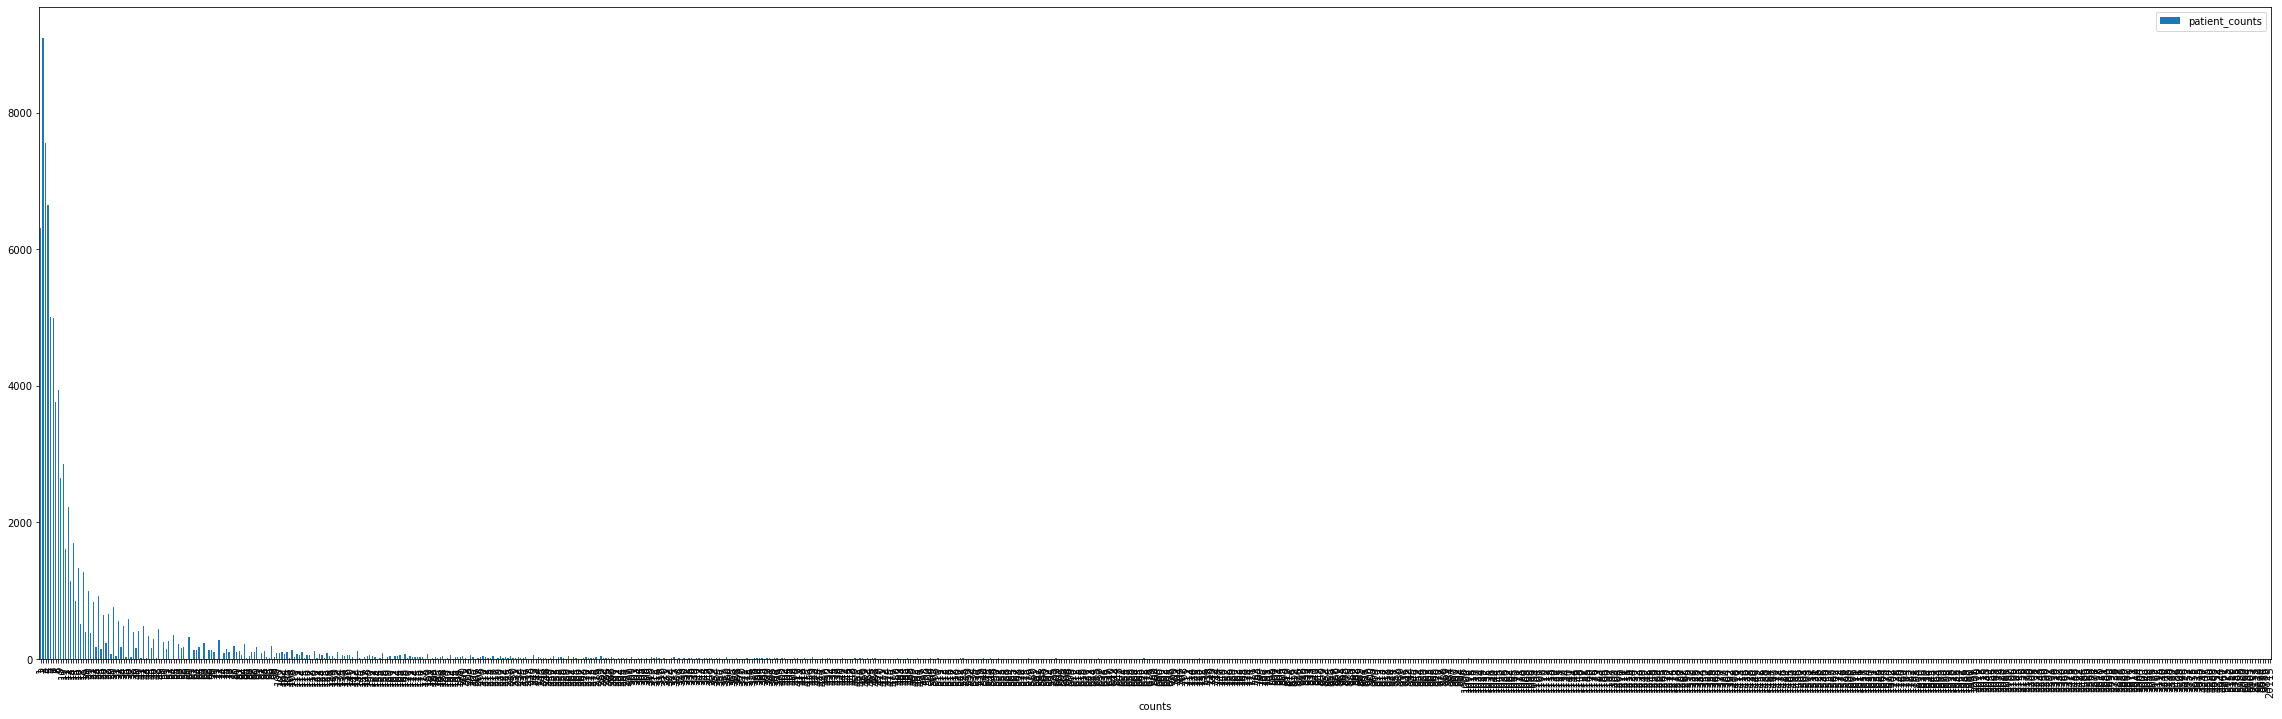

In [141]:
icd10_codes_df.groupby(['dim_patient_sid']).size().reset_index(name='counts').sort_values(by='counts')\
 .groupby(["counts"]).size().reset_index(name='patient_counts').set_index("counts").sort_values(by='counts').plot(kind="bar", figsize=(40,12))

In [143]:
icd10_codes_df.groupby(['dim_patient_sid']).size().reset_index(name='counts').sort_values(by='counts').median()

dim_patient_sid    1055963.0
counts                   7.0
dtype: float64

In [144]:
extend_by_missing_patients(icd10_codes_df.groupby(['dim_patient_sid']).size().reset_index(name='counts'),
                           all_patients_df, na_find="counts", na_replace=0).sort_values(by='counts').median()

dim_patient_sid     1093307.0
dim_patient_bk     12605360.0
Patient ID int     12605360.0
counts                    5.0
dtype: float64

## TACS_DATEN (Patient-Employee contacts)

In [95]:
tacs_df = pd.read_csv(base_folder + "TACS_DATEN.csv", dtype=str, parse_dates=["datum_betreuung"], encoding="ISO-8859-1")

In [96]:
tacs_df.drop(["patient_typ", "patient_status", 'fall_typ', 'fall_status', 'mitarbeiter_anstellungsnummer', 'mitarbeiter_login', 'BATCH_RUN_ID'], axis=1, inplace=True)

In [97]:
tacs_df

,patient_patientid,fall_nummer,datum_betreuung,dauer_betreuung_in_min,mitarbeiter_personalnummer
0,00014549581,0006724219,2018-10-17,60,0086309
1,00012294594,0006763222,2018-10-17,10,0078312
2,00015013642,0006753148,2018-10-17,90,0078312
3,00015013642,0006753148,2018-10-17,60,0078312
4,00007916221,0006418999,2018-05-16,14,0071448
...,...,...,...,...,...
14217550,00015440915,0007143486,2019-07-08,30,0324821
14217551,00015526216,0007181733,2019-07-08,70,0316865
14217552,00015526216,0007181733,2019-07-08,50,0316865
14217553,00008415714,0007179793,2019-07-08,30,5005034


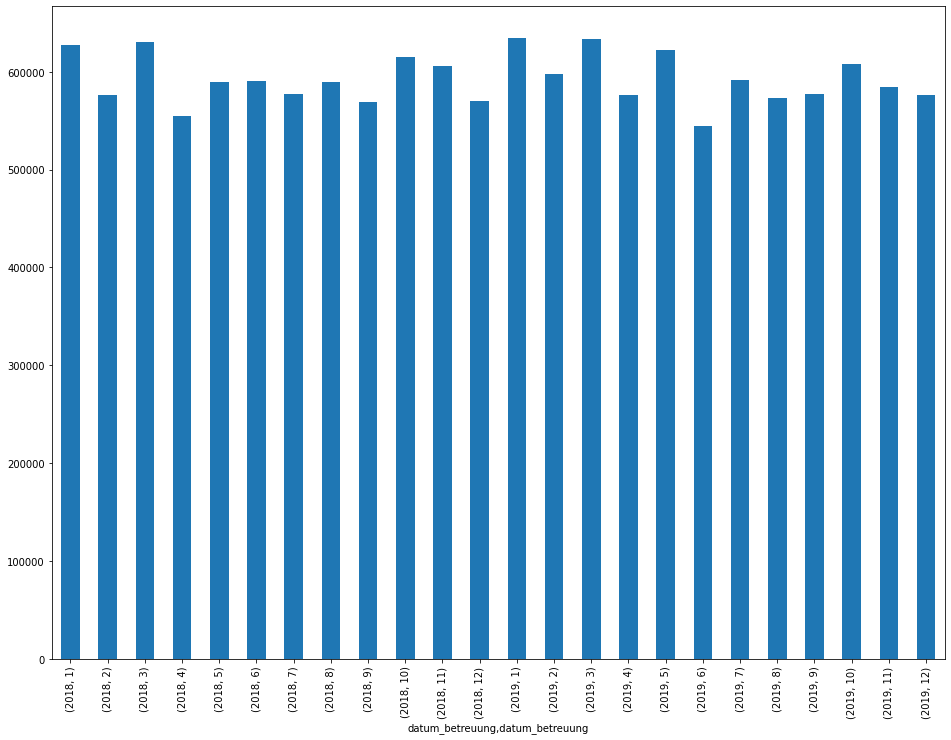

In [98]:
plot_date_histogram_of_col(tacs_df, col="datum_betreuung", by_month=True)

### Treatments by patient

<AxesSubplot:xlabel='care_counts'>

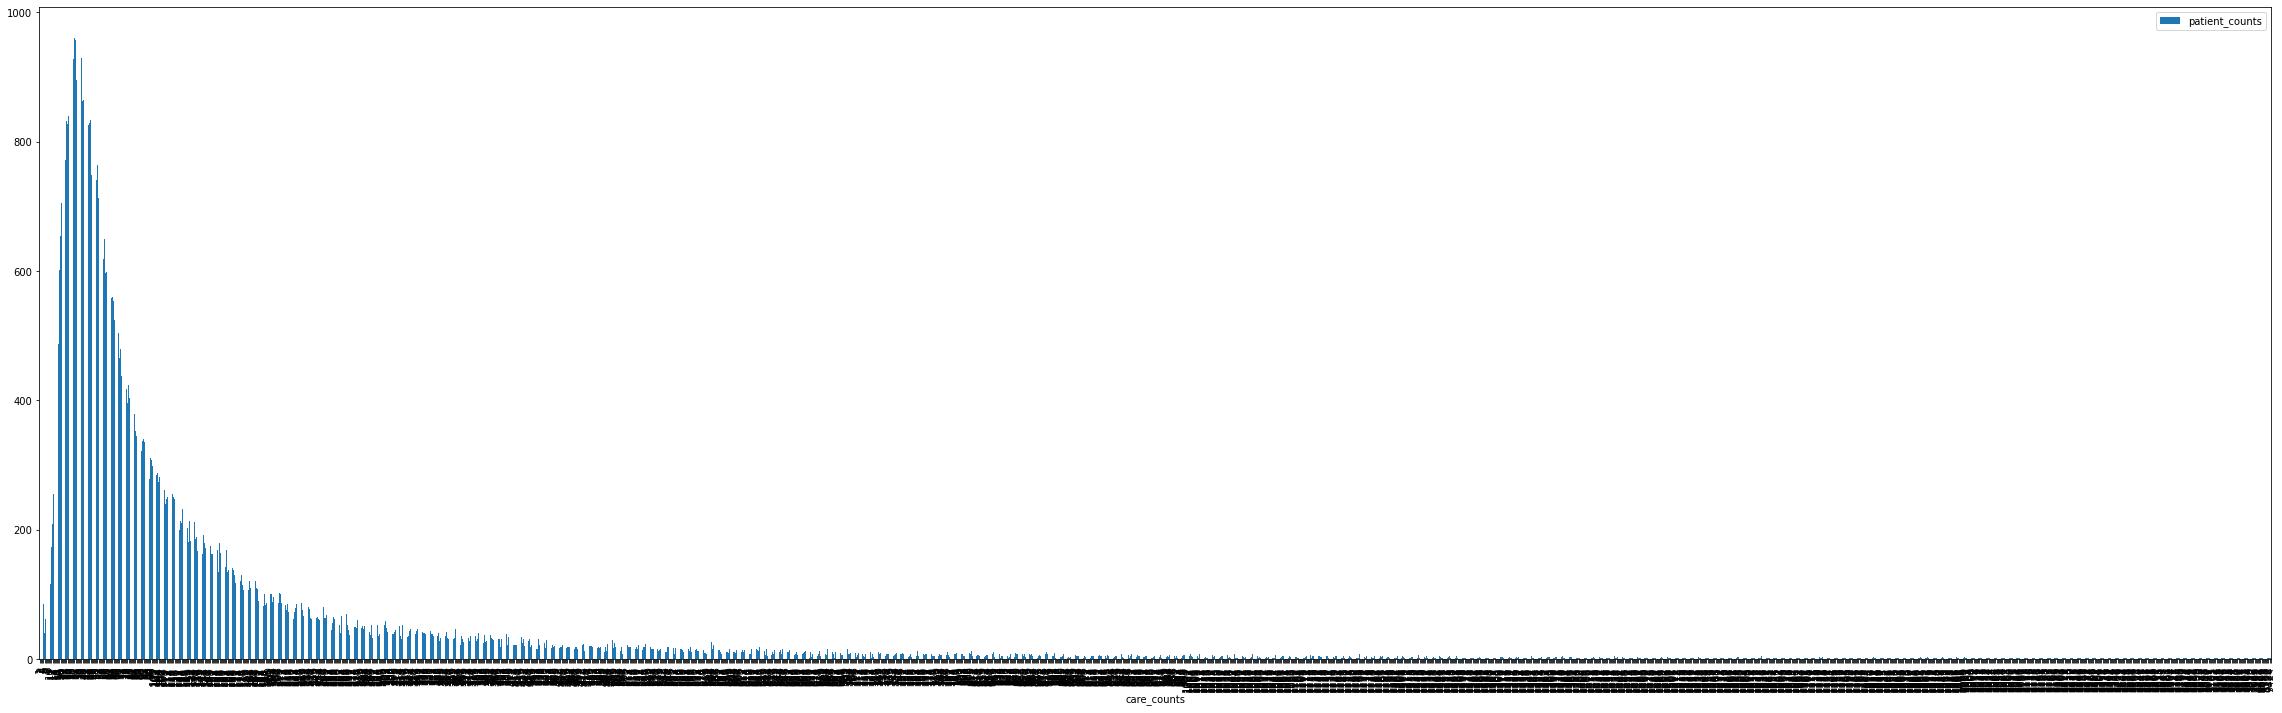

In [99]:
tacs_df.groupby(['patient_patientid']).size().reset_index(name='care_counts').sort_values(by='care_counts')\
 .groupby(["care_counts"]).size().reset_index(name='patient_counts').set_index("care_counts").sort_values(by='care_counts').plot(kind="bar", figsize=(40,12))

### Treatments by Case

<AxesSubplot:xlabel='care_counts'>

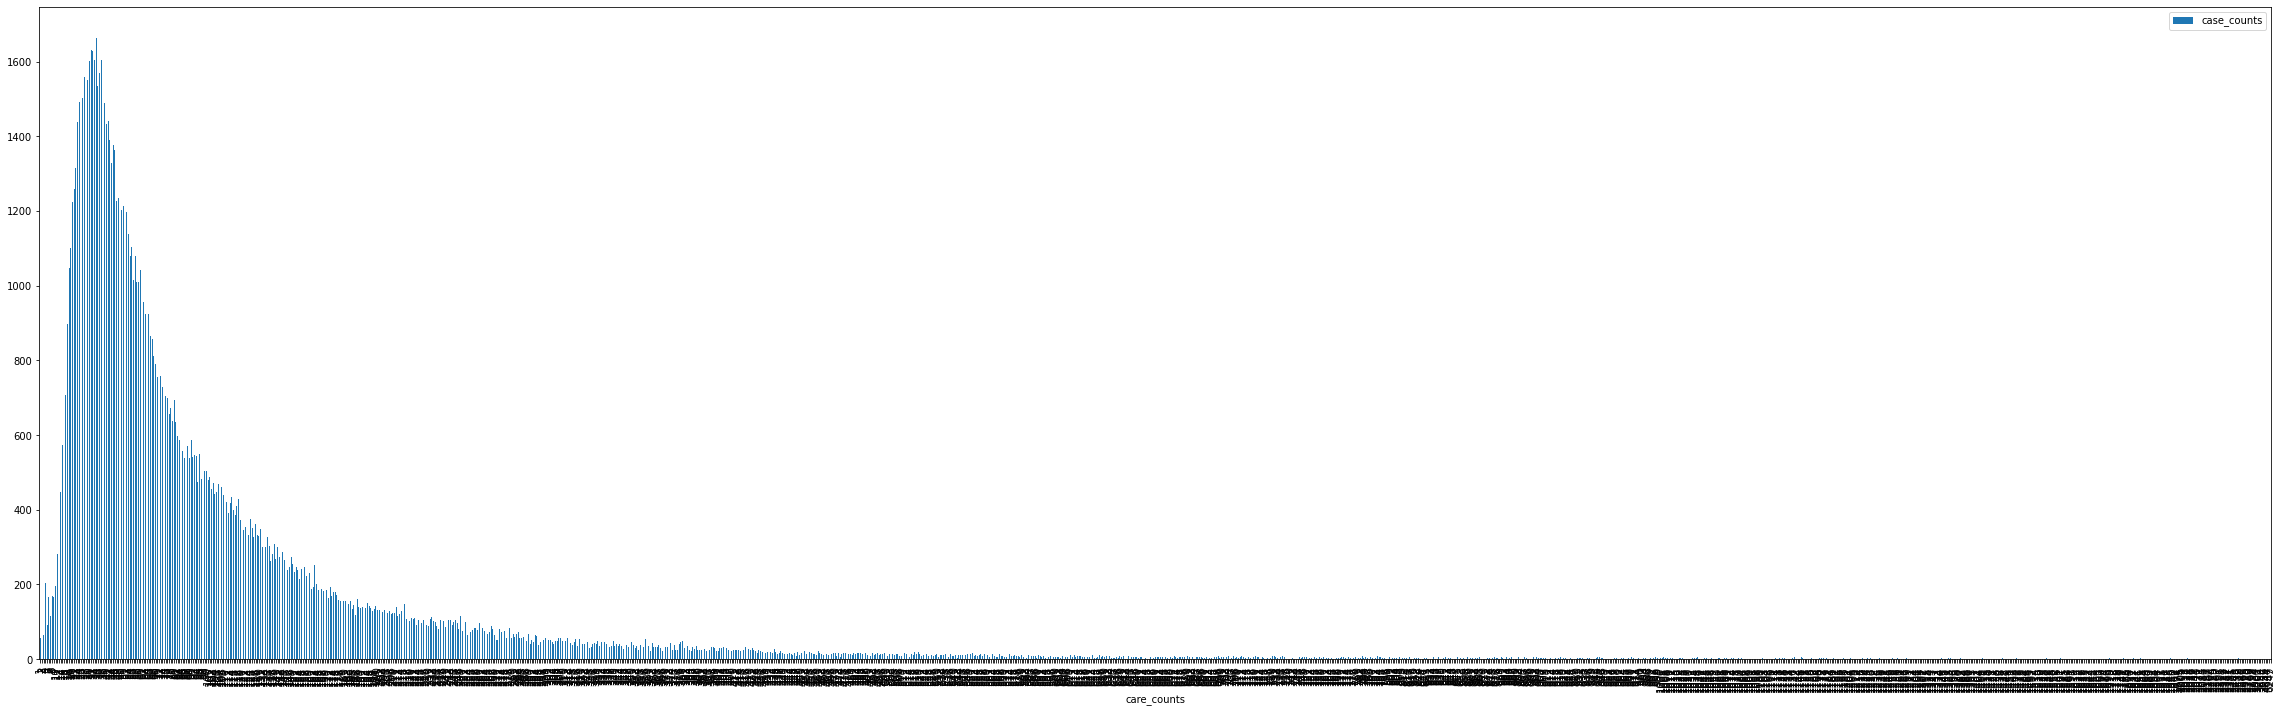

In [100]:
tacs_df.groupby(['fall_nummer']).size().reset_index(name='care_counts').sort_values(by='care_counts')\
 .groupby(["care_counts"]).size().reset_index(name='case_counts').set_index("care_counts").sort_values(by='care_counts').plot(kind="bar", figsize=(40,12))

### Median of people that have treatments

In [101]:
tacs_df.groupby(['patient_patientid']).size().reset_index(name='care_counts').sort_values(by='care_counts').median()

patient_patientid    12091944.0
care_counts                75.0
dtype: float64

## VRE_SCREENING_DATA

In [102]:
vre_screening_df = pd.read_csv(base_folder + "VRE_SCREENING_DATA.csv", dtype=str, parse_dates=["Record Date", "Birth Date"], index_col=0) # encoding="ISO-8859-1", 

In [103]:
vre_screening_df["Patient ID"] = vre_screening_df["Patient ID"].apply(lambda s: ''.join(c for c in s if c.isdigit()))

In [104]:
vre_screening_df["Patient ID int"] = pd.to_numeric(vre_screening_df["Patient ID"])

In [105]:
vre_screening_df

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,Patient ID int
0,2803033,2017-12-30,2017-12-29,Roland,Streiff,1965-10-04,00013253506,nn,13253506
2,2803035,2017-12-30,2017-12-29,Roland,Rüfenacht,1956-01-18,00006240593,nn,6240593
3,2803036,2017-12-30,2017-12-29,Pia,Petrick Ibele,1949-04-11,00011897031,nn,11897031
4,2803037,2017-12-30,2017-12-29,Roland,Steffen,1963-03-27,00014303736,nn,14303736
5,2803038,2017-12-30,2017-12-29,Eloina,Perez Castaedo,1944-03-13,0005040779,nn,5040779
...,...,...,...,...,...,...,...,...,...
15632,3255143,2020-08-07,2020-08-07,Lina,Heiniger,1933-12-13,6950671,nn,6950671
11418,3254955,2020-08-07,2020-08-06,Mohammed,Sallam,1979-12-28,15982815,nn,15982815
19175,3255465,2020-08-08,2020-08-08,Badou,Diop,1992-02-04,16219260,nn,16219260
8572,3255481,2020-08-08,2020-08-08,Silvia,Siegrist Elshani,1959-05-08,12573124,nn,12573124


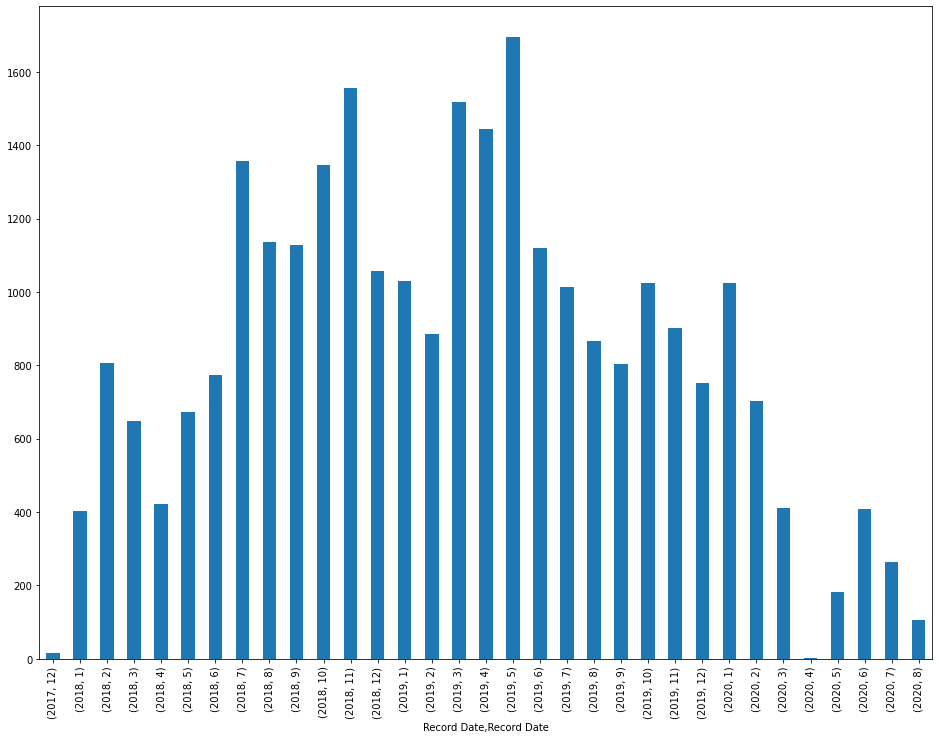

In [106]:
plot_date_histogram_of_col(vre_screening_df, col="Record Date", by_month=True)

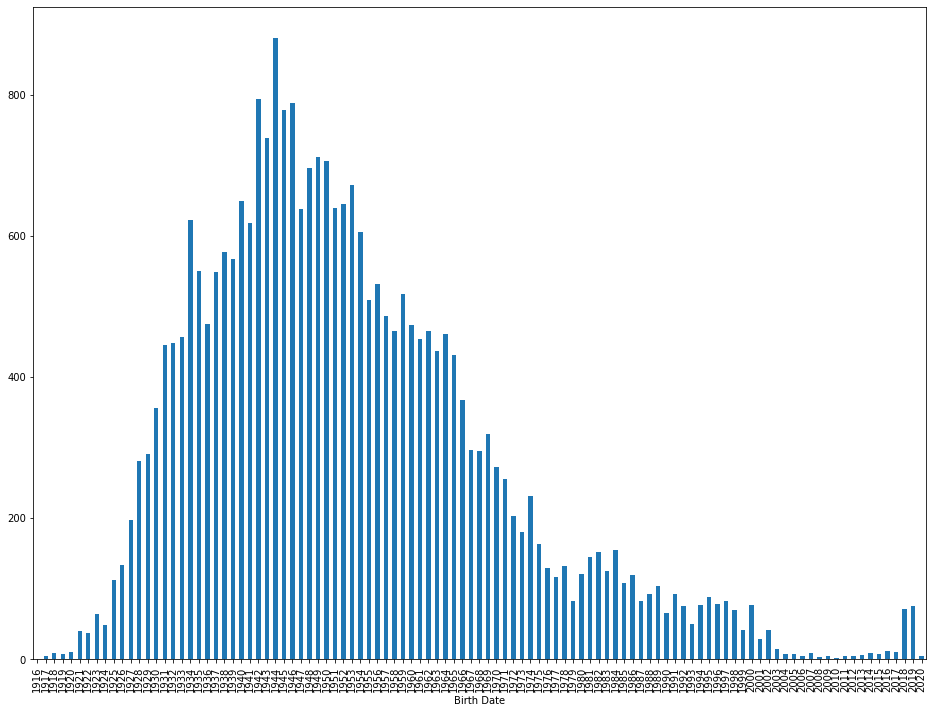

In [107]:
plot_date_histogram_of_col(vre_screening_df, col="Birth Date", by_month=False)

In [108]:
evaluate_col_classes(vre_screening_df)

CATEGORICAL: Column name: Order ID, dtype: object, values: ['2803033' '2803035' '2803036' ... '3255465' '3255481' '3255507']
UNKNOWN: Column name: Record Date, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: Measurement Date, dtype: object, values: ['2017-12-29' '2018-01-03' nan '2018-01-05' '2018-01-02' '2018-01-06'
 '2018-01-08' '2018-01-09' '2018-01-10' '2018-01-11' '2018-01-12'
 '2018-01-14' '2018-01-15' '2018-01-13' '2018-01-16' '2018-01-17'
 '2018-01-18' '2018-01-19' '2018-01-20' '2018-01-21' '2018-02-21'
 '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-26'
 '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04' '2018-02-05'
 '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09' '2018-02-10'
 '2018-02-12' '2018-02-11' '2018-02-13' '2018-02-14' '2018-02-15'
 '2018-02-16' '2018-02-17' '2018-02-19' '2018-02-20' '2018-02-22'
 '2018-12-22' '2018-02-23' '2018-02-24' '2018-02-25' '2018-02-26'
 '2

In [109]:
v_df1 = vre_screening_df
v_df1[~v_df1["Pathogen Result"].str.contains("nn")]

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,Patient ID int
6,2803039,2017-12-30,2017-12-29,Kurt,Roten,1935-02-27,00014404079,efam,14404079
7,2803040,2017-12-30,2017-12-29,Rosmarie,Maurer,1953-01-22,00007420510,efam,7420510
11,2803114,2017-12-31,2017-12-29,Christophe,Tivollier,1969-11-12,00011739495,efam,11739495
10,2803113,2017-12-31,2017-12-29,Philippe,Jaques,1957-02-03,00003324494,efam,3324494
19,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,efam,11639563
...,...,...,...,...,...,...,...,...,...
12643,3221801,2020-06-11,2020-06-10,Rosa,Lehmann,1927-11-10,3625222,pp,3625222
2409,3232554,2020-06-29,2020-06-29,Robert Ernst,Stucki,1935-12-22,7020015,pp,7020015
603,3237067,2020-07-06,2020-07-06,Gottfried,Iseli,1943-12-18,8120552,pp,8120552
16133,3242360,2020-07-13,2020-07-13,Paul,Friedli,1937-01-21,6453821,pp,6453821


In [110]:
pd.set_option('display.max_rows', 2000)
v_df1[~v_df1["Pathogen Result"].str.contains("nn")].sort_values(by=["Record Date"])

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,Patient ID int
6,2803039,2017-12-30,2017-12-29,Kurt,Roten,1935-02-27,00014404079,efam,14404079
7,2803040,2017-12-30,2017-12-29,Rosmarie,Maurer,1953-01-22,00007420510,efam,7420510
11,2803114,2017-12-31,2017-12-29,Christophe,Tivollier,1969-11-12,00011739495,efam,11739495
10,2803113,2017-12-31,2017-12-29,Philippe,Jaques,1957-02-03,00003324494,efam,3324494
19,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,efam,11639563
21,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,efam,82358079
24,2804106,2018-01-03,2018-01-03,Adrian,Bürgisser,1977-11-08,00007348037,efam,7348037
37,2804169,2018-01-04,2018-01-03,Francoise,Baur,1957-08-10,00000504327,efam,504327
55,2805240,2018-01-06,2018-01-05,Rita,Amiet,1955-03-19,00011407239,efam,11407239
70,2806266,2018-01-09,NaN,Francoise,Baur,1957-08-10,00000504327,efam,504327


In [111]:
len(v_df1[~v_df1["Pathogen Result"].str.contains("nn")].sort_values(by=["Record Date"]))

743

In [112]:
v_df_pos = v_df1[~v_df1["Pathogen Result"].str.contains("nn")]
v_df_pos["Pathogen Result"] = "pp"
v_df_pos = v_df_pos.drop_duplicates(subset=["Pathogen Result", "Patient ID"]).sort_values(by=["Record Date"])
v_df_pos

/home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,Patient ID int
6,2803039,2017-12-30,2017-12-29,Kurt,Roten,1935-02-27,00014404079,pp,14404079
7,2803040,2017-12-30,2017-12-29,Rosmarie,Maurer,1953-01-22,00007420510,pp,7420510
11,2803114,2017-12-31,2017-12-29,Christophe,Tivollier,1969-11-12,00011739495,pp,11739495
10,2803113,2017-12-31,2017-12-29,Philippe,Jaques,1957-02-03,00003324494,pp,3324494
19,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,pp,11639563
21,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,pp,82358079
24,2804106,2018-01-03,2018-01-03,Adrian,Bürgisser,1977-11-08,00007348037,pp,7348037
37,2804169,2018-01-04,2018-01-03,Francoise,Baur,1957-08-10,00000504327,pp,504327
55,2805240,2018-01-06,2018-01-05,Rita,Amiet,1955-03-19,00011407239,pp,11407239
156,2808360,2018-01-12,NaN,Pia,Petrick Ibele,1949-04-11,00011897031,pp,11897031


In [113]:
len(v_df_pos)

592

In [114]:
import datetime
date_v_df_pos = v_df_pos[(v_df_pos["Record Date"] > datetime.datetime(2017, 12, 31)) & (v_df_pos["Record Date"] < datetime.datetime(2029, 1, 1))]

In [115]:
len(date_v_df_pos)

588

In [116]:
all_patients_df["Patient ID int"] = pd.to_numeric(all_patients_df["dim_patient_bk"])

/home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [117]:
date_v_df_pos = date_v_df_pos.merge(all_patients_df, how="left", on="Patient ID int").drop(["Patient ID int", 'dim_patient_bk'], axis=1)

In [118]:
date_v_df_pos[date_v_df_pos["dim_patient_sid"].isna()].merge(dim_patient_df, how="left", left_on=["First Name", "Last Name", "Birth Date"], right_on=["dim_patient_vorname", "dim_patient_nachname", "dim_patient_geburtsdatum"])

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,dim_patient_sid_x,dim_patient_sid_y,dim_patient_bk,dim_patient_pid_int,dim_patient_vorname,dim_patient_nachname,dim_patient_geschlecht,dim_patient_geburtsdatum
0,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,2818963,2018-02-05,2018-02-05,Cabdinasir,Xasan Cismaciil,1988-01-01,00009231285,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2830951,2018-03-02,2018-03-02,Stefanie,Küng,1996-10-02,00013771299,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,2907380,2018-08-16,2018-08-16,Eileen,Benz,1991-11-02,00012412481,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,2928339,2018-09-27,2018-09-27,Berta,Thierstein-Schneider,1930-10-18,00000532646,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5,2931786,2018-10-05,2018-10-05,Verena,Wegmüller-Burger,1940-05-09,00000555536,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,2931785,2018-10-05,2018-10-04,Anna,Jakob,1936-11-09,00000661920,pp,NaN,31674,00002355884,2355884,Anna,Jakob,weiblich,1936-11-09
7,3121536,2019-11-14,2019-11-13,Eva,Rothacher,1962-01-25,10949810,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8,3144942,2020-01-07,2020-01-07,Giuseppe,Faggiano,1983-12-01,9224602,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9,3152193,2020-01-21,2020-01-21,Alfred,Friedli,1943-03-12,15870871,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [127]:
date_v_df_pos.merge(dim_patient_df, how="left", left_on=["First Name", "Last Name", "Birth Date"], right_on=["dim_patient_vorname", "dim_patient_nachname", "dim_patient_geburtsdatum"])

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,dim_patient_sid_x,dim_patient_sid_y,dim_patient_bk,dim_patient_pid_int,dim_patient_vorname,dim_patient_nachname,dim_patient_geschlecht,dim_patient_geburtsdatum
0,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,pp,793989,793989,00011639563,11639563,Fritz,Hämmerli,männlich,1947-07-14
1,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,pp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2804106,2018-01-03,2018-01-03,Adrian,Bürgisser,1977-11-08,00007348037,pp,630769,630769,00007348037,7348037,Adrian,Bürgisser,männlich,1977-11-08
3,2804169,2018-01-04,2018-01-03,Francoise,Baur,1957-08-10,00000504327,pp,305956,305956,00000504327,504327,Francoise,Baur,weiblich,1957-08-10
4,2805240,2018-01-06,2018-01-05,Rita,Amiet,1955-03-19,00011407239,pp,1115091,1115091,00011407239,11407239,Rita,Amiet,weiblich,1955-03-19
5,2808360,2018-01-12,NaN,Pia,Petrick Ibele,1949-04-11,00011897031,pp,778222,778222,00011897031,11897031,Pia,Petrick Ibele,weiblich,1949-04-11
6,2809627,2018-01-16,2018-01-16,Gordana,Milosevic,1980-03-10,00000018996,pp,10866,10866,00000018996,18996,Gordana,Milosevic,weiblich,1980-03-10
7,2812787,2018-01-23,2018-01-23,Verena,Renfer,1948-08-11,00014367394,pp,1374853,1374853,00014367394,14367394,Verena,Renfer,weiblich,1948-08-11
8,2813758,2018-01-24,2018-01-24,René,Scheidegger,1957-07-31,00001256122,pp,501497,501497,00001256122,1256122,René,Scheidegger,männlich,1957-07-31
9,2814089,2018-01-25,2018-01-25,Ilona,Leutwyler,1954-04-27,00014537257,pp,1306975,1306975,00014537257,14537257,Ilona,Leutwyler,weiblich,1954-04-27


In [131]:
date_v_df_pos

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,dim_patient_sid
0,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,pp,793989
1,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,pp,NaN
2,2804106,2018-01-03,2018-01-03,Adrian,Bürgisser,1977-11-08,00007348037,pp,630769
3,2804169,2018-01-04,2018-01-03,Francoise,Baur,1957-08-10,00000504327,pp,305956
4,2805240,2018-01-06,2018-01-05,Rita,Amiet,1955-03-19,00011407239,pp,1115091
5,2808360,2018-01-12,NaN,Pia,Petrick Ibele,1949-04-11,00011897031,pp,778222
6,2809627,2018-01-16,2018-01-16,Gordana,Milosevic,1980-03-10,00000018996,pp,10866
7,2812787,2018-01-23,2018-01-23,Verena,Renfer,1948-08-11,00014367394,pp,1374853
8,2813758,2018-01-24,2018-01-24,René,Scheidegger,1957-07-31,00001256122,pp,501497
9,2814089,2018-01-25,2018-01-25,Ilona,Leutwyler,1954-04-27,00014537257,pp,1306975


In [120]:
date_v_df_pos["dim_patient_sid"].isna().sum()

17

In [124]:
date_v_df_pos[date_v_df_pos["dim_patient_sid"].isna()].reset_index()

,index,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,dim_patient_sid
0,1,2804010,2018-01-03,NaN,Andreas,Wiesendanger,1945-10-29,00082358079,pp,NaN
1,17,2818963,2018-02-05,2018-02-05,Cabdinasir,Xasan Cismaciil,1988-01-01,00009231285,pp,NaN
2,50,2830951,2018-03-02,2018-03-02,Stefanie,Küng,1996-10-02,00013771299,pp,NaN
3,192,2907380,2018-08-16,2018-08-16,Eileen,Benz,1991-11-02,00012412481,pp,NaN
4,240,2928339,2018-09-27,2018-09-27,Berta,Thierstein-Schneider,1930-10-18,00000532646,pp,NaN
5,243,2931786,2018-10-05,2018-10-05,Verena,Wegmüller-Burger,1940-05-09,00000555536,pp,NaN
6,244,2931785,2018-10-05,2018-10-04,Anna,Jakob,1936-11-09,00000661920,pp,NaN
7,520,3121536,2019-11-14,2019-11-13,Eva,Rothacher,1962-01-25,10949810,pp,NaN
8,559,3144942,2020-01-07,2020-01-07,Giuseppe,Faggiano,1983-12-01,9224602,pp,NaN
9,566,3152193,2020-01-21,2020-01-21,Alfred,Friedli,1943-03-12,15870871,pp,NaN


In [130]:
~date_v_df_pos["dim_patient_sid"].isna()

0       True
1      False
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17     False
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
30      True
31      True
32      True
33      True
34      True
35      True
36      True
37      True
38      True
39      True
40      True
41      True
42      True
43      True
44      True
45      True
46      True
47      True
48      True
49      True
50     False
51      True
52      True
53      True
54      True
55      True
56      True
57      True
58      True
59      True
60      True
61      True
62      True
63      True
64      True
65      True
66      True
67      True
68      True
69      True
70      True
71      True
72      True
73      True
74      True
75      True
76      True

In [133]:
mergable_vre_pos_df = date_v_df_pos[~date_v_df_pos["dim_patient_sid"].isna()].reset_index().drop(["index"], axis=1)

In [134]:
mergable_vre_pos_df

,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result,dim_patient_sid
0,2804008,2018-01-03,2018-01-03,Fritz,Hämmerli,1947-07-14,00011639563,pp,793989
1,2804106,2018-01-03,2018-01-03,Adrian,Bürgisser,1977-11-08,00007348037,pp,630769
2,2804169,2018-01-04,2018-01-03,Francoise,Baur,1957-08-10,00000504327,pp,305956
3,2805240,2018-01-06,2018-01-05,Rita,Amiet,1955-03-19,00011407239,pp,1115091
4,2808360,2018-01-12,NaN,Pia,Petrick Ibele,1949-04-11,00011897031,pp,778222
5,2809627,2018-01-16,2018-01-16,Gordana,Milosevic,1980-03-10,00000018996,pp,10866
6,2812787,2018-01-23,2018-01-23,Verena,Renfer,1948-08-11,00014367394,pp,1374853
7,2813758,2018-01-24,2018-01-24,René,Scheidegger,1957-07-31,00001256122,pp,501497
8,2814089,2018-01-25,2018-01-25,Ilona,Leutwyler,1954-04-27,00014537257,pp,1306975
9,2814343,2018-01-25,2018-01-25,Kenan,Mahmut,1984-11-25,00014541866,pp,1317377


These are probably not inpatients (?)

In [135]:
mergable_vre_pos_df.to_csv(base_folder + "dd_vre_positive.csv", encoding="utf-8")